# CUSTOMER SEGMENTATION PROJECT

- Về doanh nghiệp: Cửa hàng X chủ yếu bán các sản phẩm thiết yếu cho khách hàng như rau, củ, quả, thịt, cá, trứng, sữa, nước giải khát... Khách hàng của cửa hàng là khách hàng mua lẻ.

- Mục tiêu : Bán được nhiều hàng hóa hơn cũng như giới thiệu sản phẩm đến đúng đối tượng khách hàng, chăm sóc và làm hài lòng khách hàng





## EDA

In [1]:
!pip install squarify
!pip install matplotlib==3.1.3

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import *
from sklearn.neighbors import NearestNeighbors
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import RobustScaler

### Preporcessing

In [4]:
df1 = pd.read_csv('/content/gdrive/MyDrive/DL07_K302_NguyenNhatToTran_NguyenVuMaiPhuong/PROJECT 1/Products_with_Categories.csv')

In [5]:
df1.head()

productId       productName  price         Category
0          1    tropical fruit    7.8       Fresh Food
1          2        whole milk    1.8            Dairy
2          3         pip fruit    3.0       Fresh Food
3          4  other vegetables    0.8       Fresh Food
4          5        rolls/buns    1.2  Bakery & Sweets

In [6]:
df2 = pd.read_csv('/content/gdrive/MyDrive/DL07_K302_NguyenNhatToTran_NguyenVuMaiPhuong/PROJECT 1/Transactions.csv')

In [7]:
df2.head()

Member_number        Date  productId  items
0           1808  21-07-2015          1      3
1           2552  05-01-2015          2      1
2           2300  19-09-2015          3      3
3           1187  12-12-2015          4      3
4           3037  01-02-2015          2      1

In [8]:
df = pd.merge(df1, df2, on='productId', how='outer')

In [9]:
df.head()

productId     productName  price    Category  Member_number        Date  \
0          1  tropical fruit    7.8  Fresh Food           1808  21-07-2015   
1          1  tropical fruit    7.8  Fresh Food           4119  12-02-2015   
2          1  tropical fruit    7.8  Fresh Food           3962  18-09-2015   
3          1  tropical fruit    7.8  Fresh Food           1088  30-11-2015   
4          1  tropical fruit    7.8  Fresh Food           1863  04-08-2015   

   items  
0      3  
1      3  
2      2  
3      2  
4      1

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productId      38765 non-null  int64  
 1   productName    38765 non-null  object 
 2   price          38765 non-null  float64
 3   Category       38765 non-null  object 
 4   Member_number  38765 non-null  int64  
 5   Date           38765 non-null  object 
 6   items          38765 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.1+ MB


In [11]:
string_to_date = lambda x : datetime.strptime(x, '%d-%m-%Y').date()

# Convert Date from object to datetime format
df['Date'] = df['Date'].apply(string_to_date)
df['Date'] = df['Date'].astype('datetime64[ns]')

df.head()

productId     productName  price    Category  Member_number       Date  \
0          1  tropical fruit    7.8  Fresh Food           1808 2015-07-21   
1          1  tropical fruit    7.8  Fresh Food           4119 2015-02-12   
2          1  tropical fruit    7.8  Fresh Food           3962 2015-09-18   
3          1  tropical fruit    7.8  Fresh Food           1088 2015-11-30   
4          1  tropical fruit    7.8  Fresh Food           1863 2015-08-04   

   items  
0      3  
1      3  
2      2  
3      2  
4      1

#### Missing values

In [12]:
df.isnull().sum()

productId        0
productName      0
price            0
Category         0
Member_number    0
Date             0
items            0
dtype: int64

In [13]:
df['purchase_amount'] = df['price'] * df['items']
df.head()

productId     productName  price    Category  Member_number       Date  \
0          1  tropical fruit    7.8  Fresh Food           1808 2015-07-21   
1          1  tropical fruit    7.8  Fresh Food           4119 2015-02-12   
2          1  tropical fruit    7.8  Fresh Food           3962 2015-09-18   
3          1  tropical fruit    7.8  Fresh Food           1088 2015-11-30   
4          1  tropical fruit    7.8  Fresh Food           1863 2015-08-04   

   items  purchase_amount  
0      3             23.4  
1      3             23.4  
2      2             15.6  
3      2             15.6  
4      1              7.8

#### Handle dulplicates

In [14]:
df.duplicated().any()

np.True_

In [15]:
df.drop_duplicates(inplace=True)
df.shape

(38521, 8)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38521 entries, 0 to 38764
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   productId        38521 non-null  int64         
 1   productName      38521 non-null  object        
 2   price            38521 non-null  float64       
 3   Category         38521 non-null  object        
 4   Member_number    38521 non-null  int64         
 5   Date             38521 non-null  datetime64[ns]
 6   items            38521 non-null  int64         
 7   purchase_amount  38521 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.6+ MB


In [ ]:
# Let’s take a closer look at the data we will need to manipulate
print('Transactions timeframe from {} to {}'.format(df['Date'].min(), df['Date'].max()))
print('{:,} transactions don\'t have a member number'.format(df[df.Member_number.isnull()].shape[0]))
print('{:,} unique Member_number'.format(len(df.Member_number.unique())))

Transactions timeframe from 2014-01-01 00:00:00 to 2015-12-30 00:00:00
0 transactions don't have a member number
3,898 unique Member_number


#### Descriptive analysis

In [ ]:
for col in df.columns:
  print(col, '-', df[col].dtypes, '-', df[col].nunique())

productId - int64 - 167
productName - object - 167
price - float64 - 90
Category - object - 11
Member_number - int64 - 3898
Date - datetime64[ns] - 728
items - int64 - 3
purchase_amount - float64 - 227


In [ ]:
num_cols=df.select_dtypes('number').columns.drop(['Member_number','productId'])
num_cols

Index(['price', 'items', 'purchase_amount'], dtype='object')

In [ ]:
cat_cols=df.select_dtypes('object').columns
cat_cols

Index(['productName', 'Category'], dtype='object')

In [ ]:
df[num_cols].describe()

price         items  purchase_amount
count  38521.000000  38521.000000     38521.000000
mean       4.305367      1.996729         8.590893
std        4.320088      0.817539         9.952770
min        0.300000      1.000000         0.300000
25%        1.250000      1.000000         2.400000
50%        2.500000      2.000000         5.200000
75%        6.100000      3.000000        10.500000
max       28.500000      3.000000        85.500000

In [ ]:
df[cat_cols].describe()

productName    Category
count        38521       38521
unique         167          11
top     whole milk  Fresh Food
freq          2455       11426

### Insights

#### Total purchases, total revenue and average purchase value


In [ ]:
# Total purchases
total_purchases = df['items'].sum()
print(total_purchases)

76916


In [ ]:
# Total revenue
total_revenue = (df['items'] * df['price']).sum()
print(total_revenue)

330929.80000000005


- Nhận xét : Tổng lượt mua trong 2 năm qua là 76,916 lượt với tổng doanh thu là 330,929.80

#### Product Analysis

In [212]:
product = df.groupby('productName').agg({'price':'mean', 'items':'sum', 'purchase_amount':'sum', 'Category': lambda x: x.mode().iloc[0]}).sort_values(by='purchase_amount', ascending=False)
product.head()

price  items  purchase_amount             Category
productName                                                            
beef                  19.5   1022          19929.0           Fresh Food
tropical fruit         7.8   2094          16333.2           Fresh Food
napkins               21.8    669          14584.2  Household & Hygiene
curd                   9.8    993           9731.4                Dairy
specialty chocolate   18.8    487           9155.6      Bakery & Sweets

In [ ]:
product.tail()

price  items  purchase_amount                 Category
productName                                                                  
frozen chicken          3.50     13             45.5  Frozen & Processed Food
rubbing alcohol         2.50     11             27.5      Household & Hygiene
make up remover         3.40      7             23.8            Personal Care
preservation products   6.75      2             13.5      Household & Hygiene
kitchen utensil         8.10      1              8.1      Household & Hygiene

In [214]:
product_item=product.sort_values(by='items', ascending=False)
product_item.head()

price  items  purchase_amount         Category
productName                                                     
whole milk          1.8   4968           8942.4            Dairy
other vegetables    0.8   3743           2994.4       Fresh Food
rolls/buns          1.2   3332           3998.4  Bakery & Sweets
soda                0.8   2970           2376.0        Beverages
yogurt              2.2   2650           5830.0            Dairy

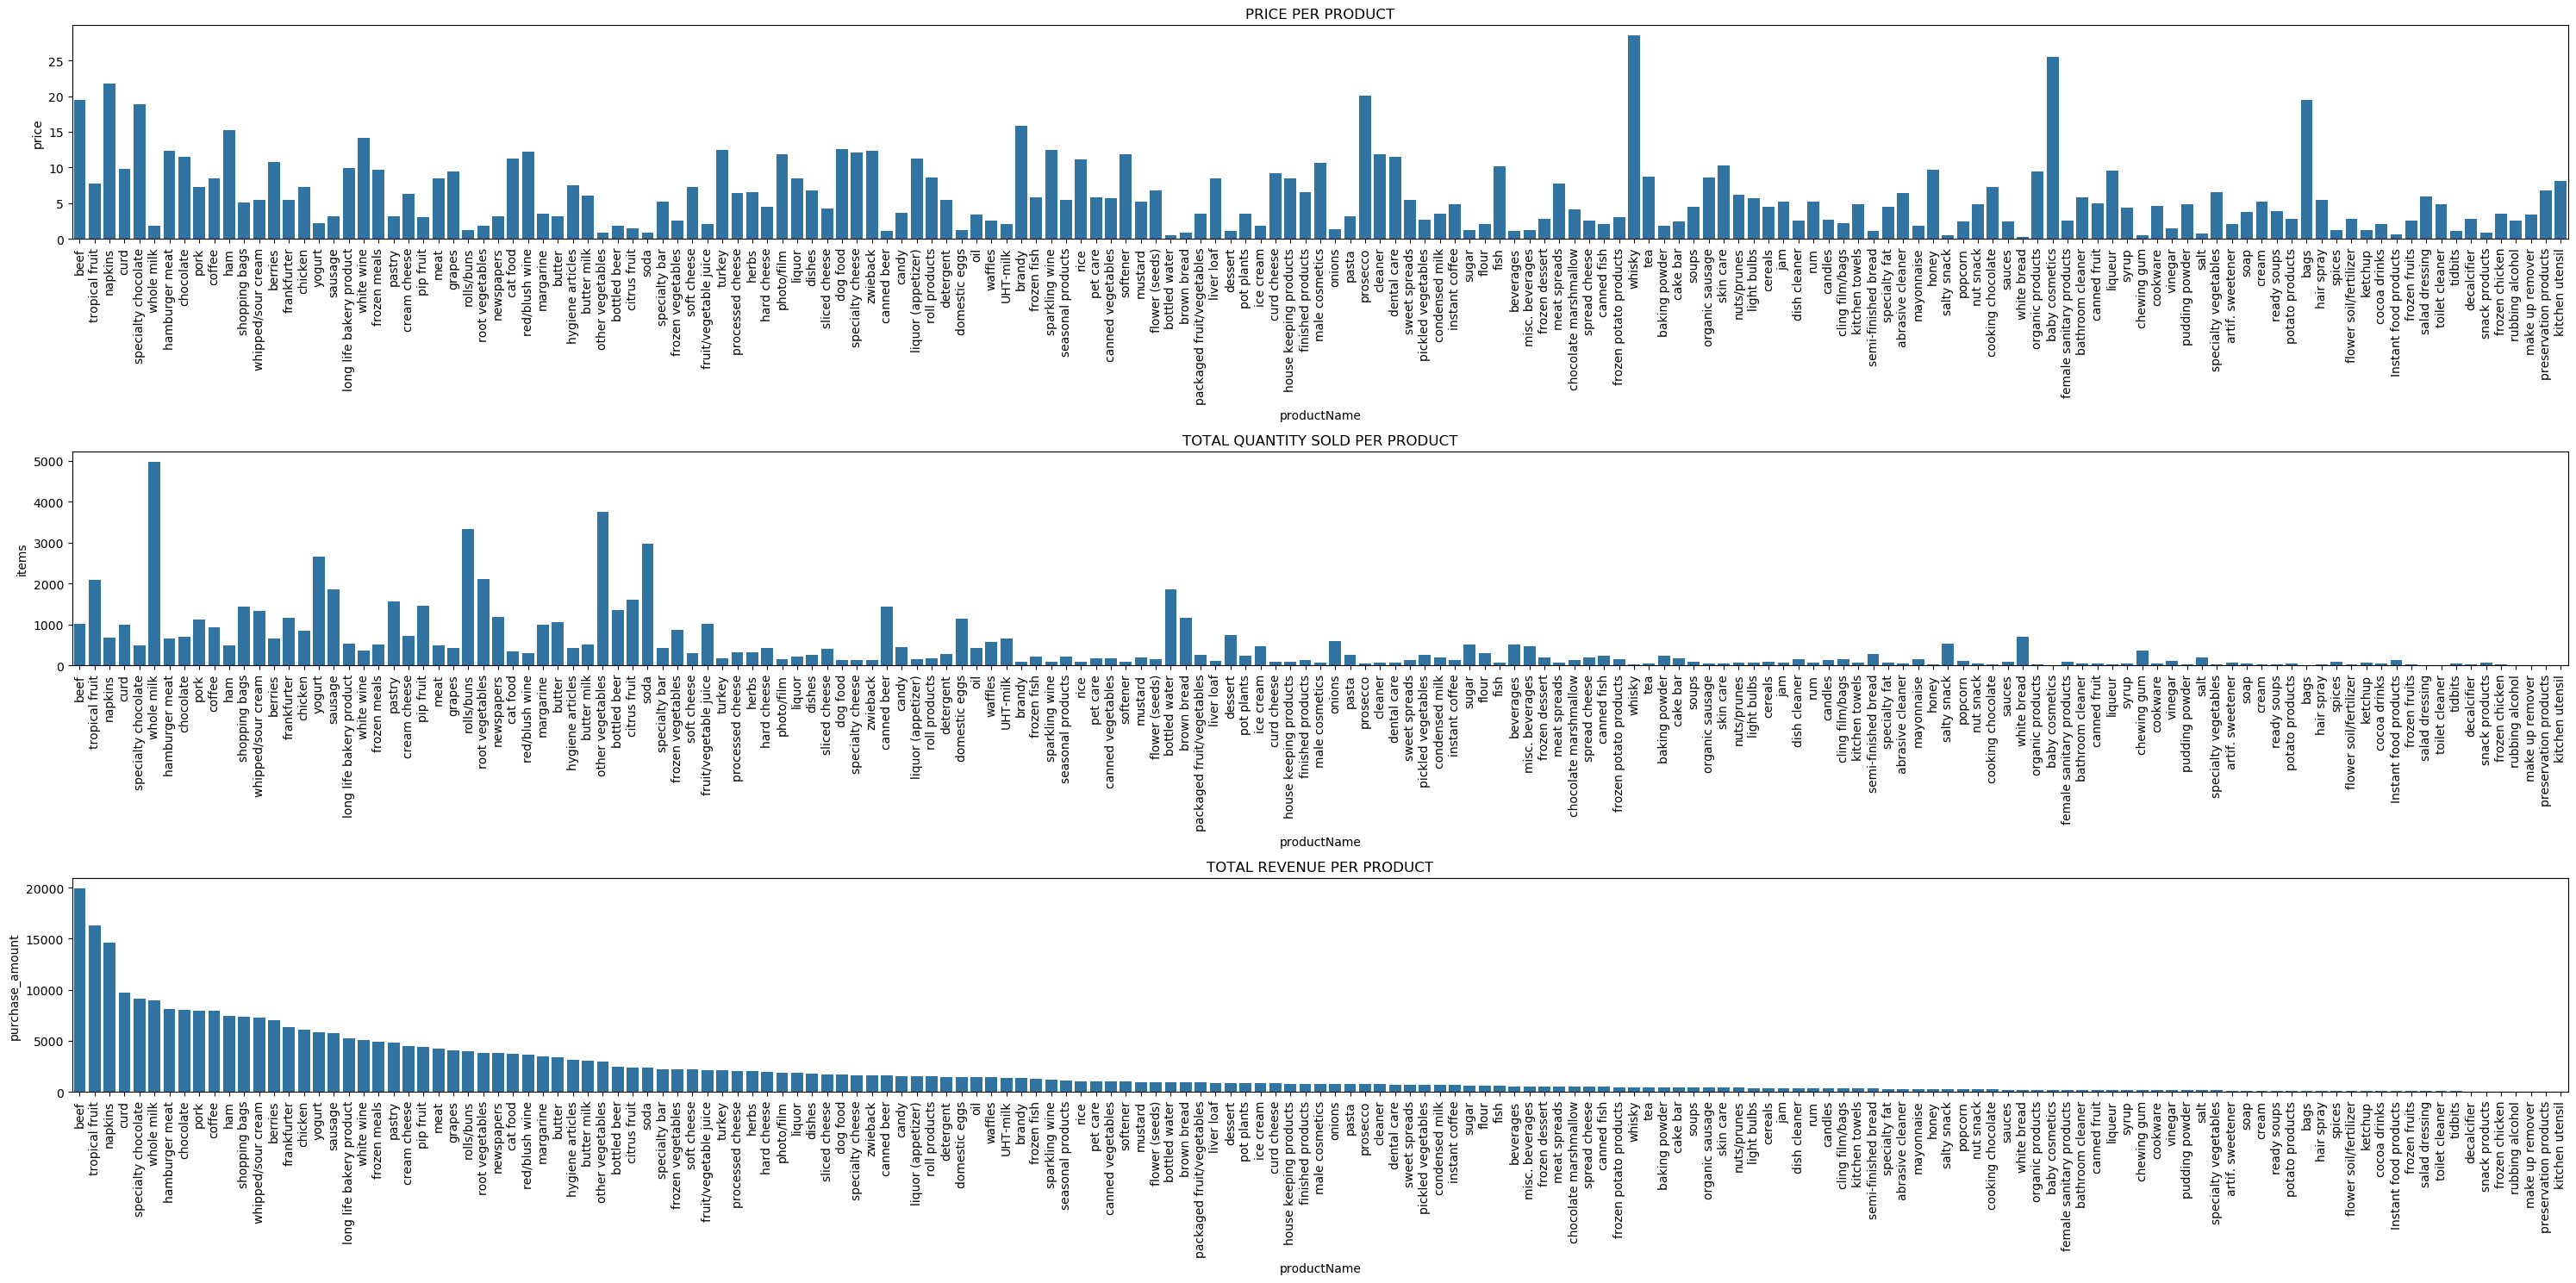

In [ ]:
plt.figure(figsize=(30,15))

plt.subplot(3,1,1)
ax1=sns.barplot(data=product, y='price', x='productName')
plt.title('PRICE PER PRODUCT')
plt.xticks(rotation=90)

plt.subplot(3,1,2)
ax2=sns.barplot(data=product, y='items', x='productName')
plt.title('TOTAL QUANTITY SOLD PER PRODUCT')
plt.xticks(rotation=90)

plt.subplot(3,1,3)
ax3=sns.barplot(data=product, y='purchase_amount', x='productName')
plt.title('TOTAL REVENUE PER PRODUCT')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

- Beef, tropical fruit, napkins, curd, specialty chocolate là các sản phẩm mang lại doanh thu nhiều nhất
- Whole milk, other vegetables, rolls/buns, soda, yogurt là các sản phẩm bán chạy nhất của cửa hàng và doanh thu mà chúng mang lại cũng khá cao
- Frozen chicken, rubbing alcohol, make up remover, preservation products, kitchen utensil là các sản phẩm bán chậm nhất của cửa hàng.

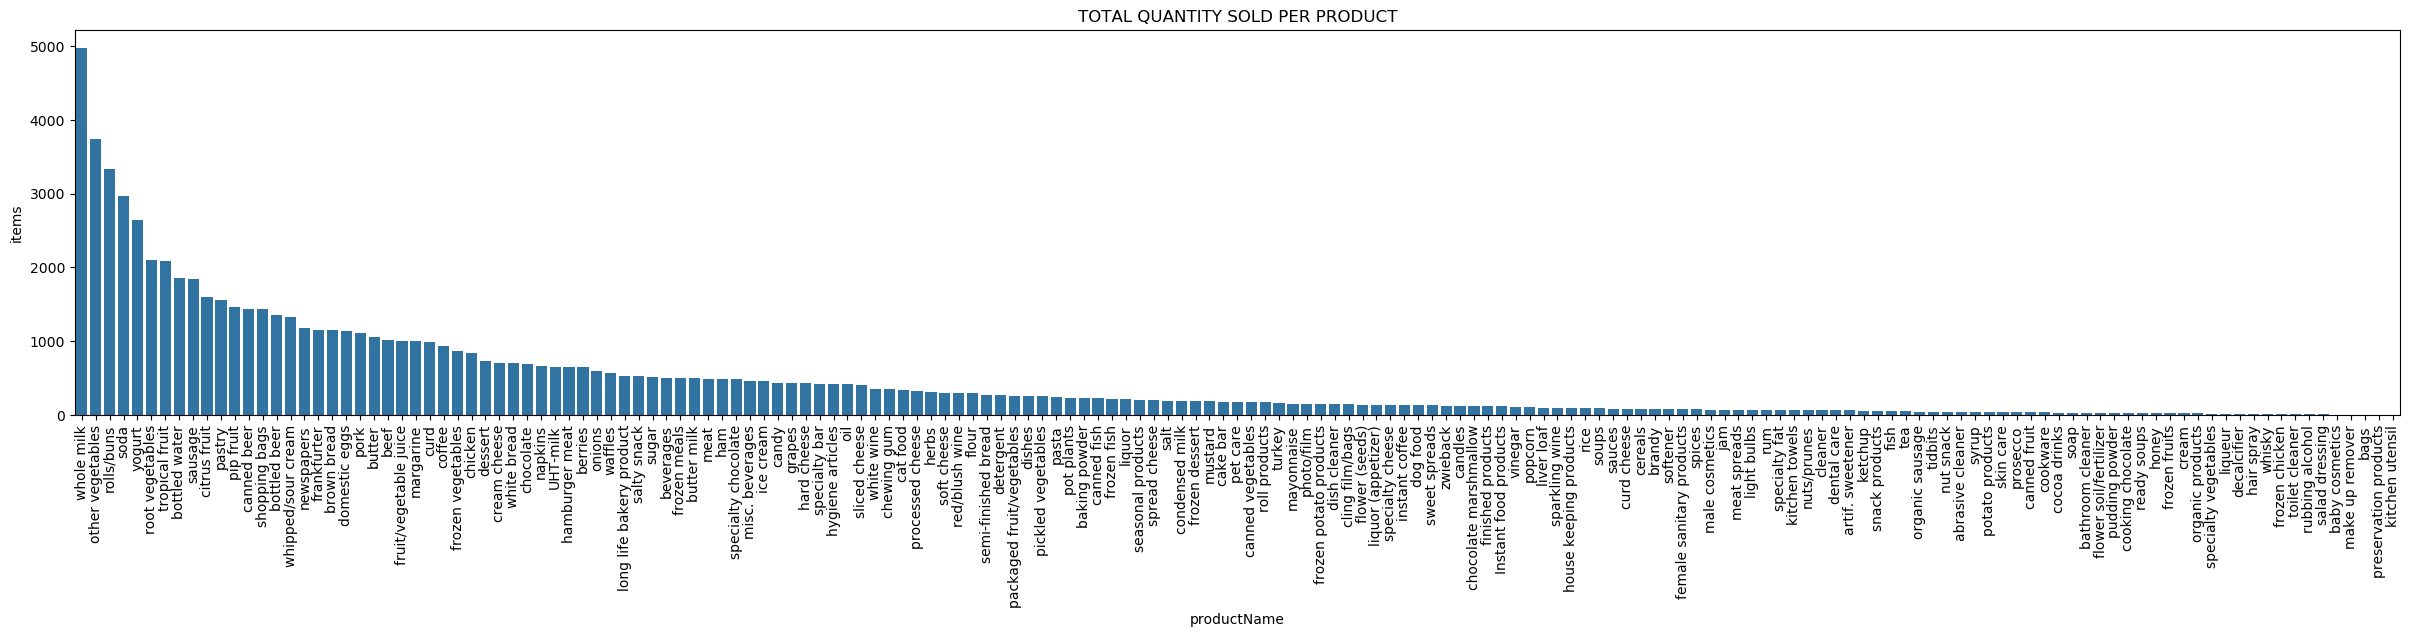

In [219]:
plt.figure(figsize=(30,5))
sns.barplot(data=product_item, y='items', x='productName')
plt.title('TOTAL QUANTITY SOLD PER PRODUCT')
plt.xticks(rotation=90)
plt.show()

#### Category Analysis

In [ ]:
category = df[['Category','items','purchase_amount']].groupby('Category').sum().sort_values(by='purchase_amount', ascending=False)
category['percent_amount'] = category['purchase_amount']/sum(category['purchase_amount'])*100
category

items  purchase_amount  percent_amount
Category                                                       
Fresh Food               22786        117566.20       35.526024
Dairy                    14968         55748.24       16.845941
Bakery & Sweets          11796         41780.78       12.625270
Household & Hygiene       4339         35555.16       10.744019
Beverages                11963         35391.10       10.694443
Frozen & Processed Food   3689         14371.92        4.342891
Pantry Staples            3134          9857.45        2.978713
Specialty & Seasonal      2360          8864.30        2.678604
Pet Care                   641          6425.80        1.941741
Snacks                     928          2727.40        0.824163
Personal Care              312          2641.45        0.798190

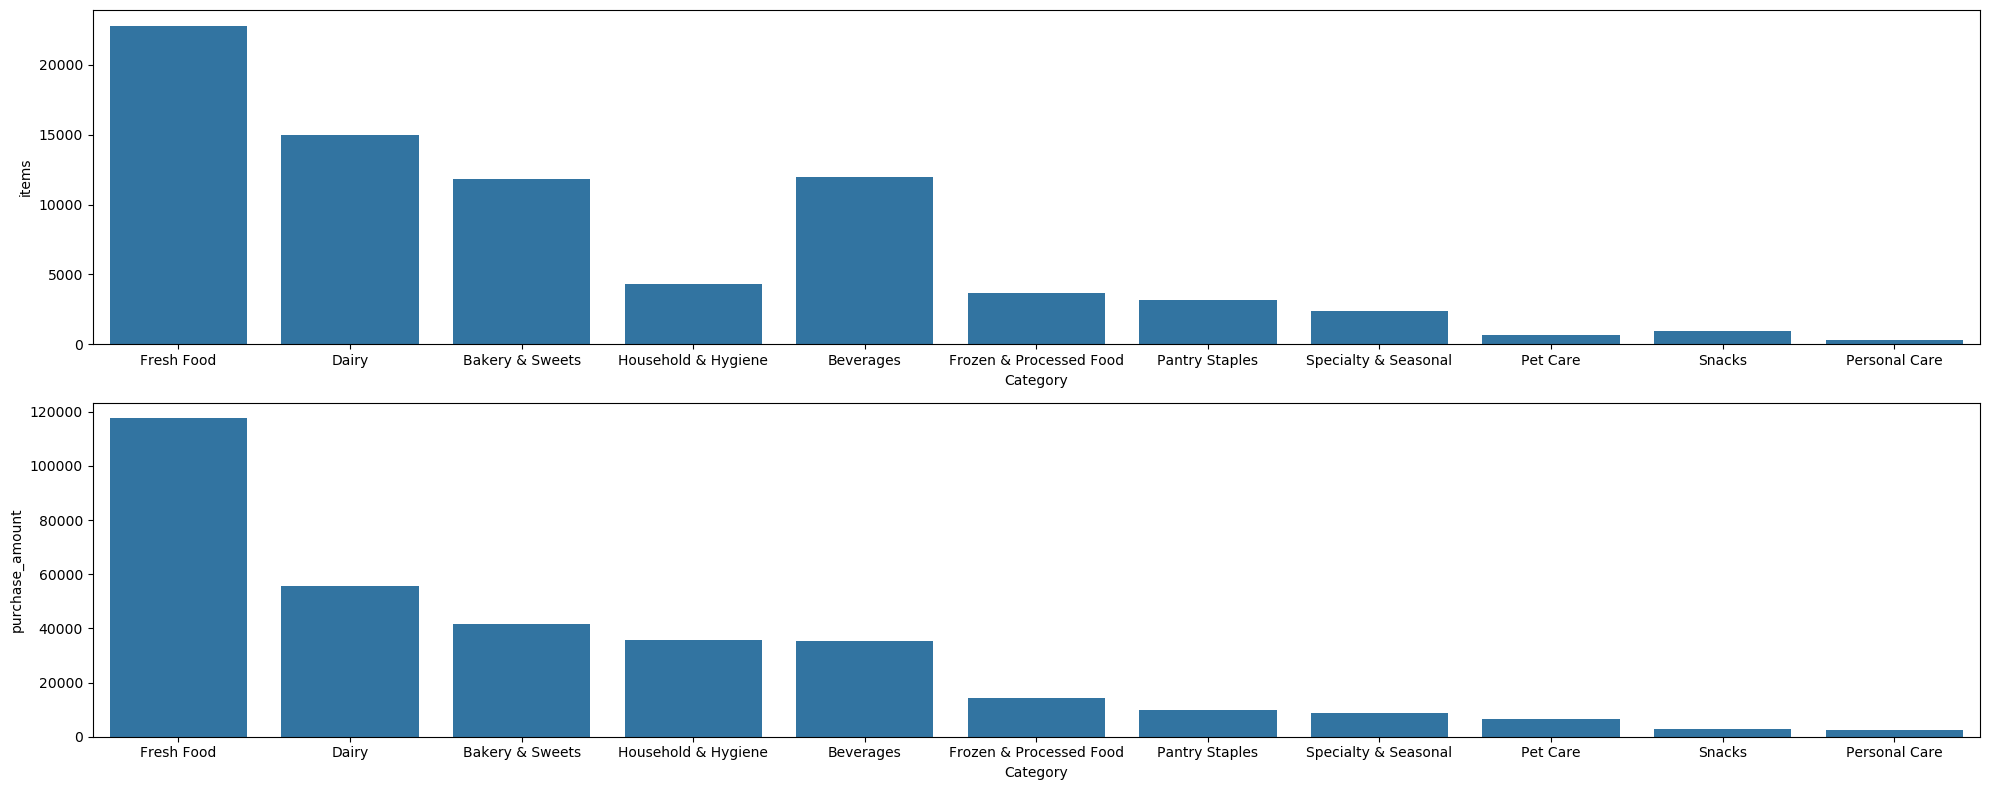

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
sns.barplot(data=category, x='Category', y='items', ax=axes[0])
sns.barplot(data=category, x='Category', y='purchase_amount', ax=axes[1])
plt.tight_layout()
plt.show()

- Fresh Food, Dairy, Bakery & Sweets là 3 ngành hàng bán chạy nhất và đóng góp hơn 60% doanh thu cửa hàng, trong đó Fresh Food đóng góp 1/3 doanh thu
- Pet Care, Snacks, Personal Care là các ngành hàng bán chậm nhất của cửa hàng

#### Customer purchasing behavior

In [ ]:
top_customers = df[['Member_number', 'items', 'purchase_amount']].groupby('Member_number').sum().sort_values(by='purchase_amount', ascending=False)
top_customers

items  purchase_amount
Member_number                        
2193              63           361.45
1793              52           345.10
3289              63           334.15
2433              57           316.81
2743              41           312.46
...              ...              ...
1560               5             1.90
1221               2             1.70
4029               2             1.60
1250               2             1.30
4565               1             1.10

[3898 rows x 2 columns]

- Nhận xét: KH 2193 là người chi tiêu nhiều nhất với 63 sản phẩm tương ứng tổng số tiền là 361.45

#### Number of Sales Weekly

In [ ]:
sales_weekly = df.resample('w', on='Date').size()
fig = px.line(df, x=sales_weekly.index, y=sales_weekly,
              labels={'y': 'Number of Sales',
                      'x': 'Date'})
fig.update_layout(title_text='Number of Sales Weekly',
                  title_x=0.5, title_font=dict(size=18))
fig.show()

<ipython-input-33-e69190597610>:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  sales_weekly = df.resample('w', on='Date').size()


#### Number of Customers Weekly

In [ ]:
unique_customer_weekly = df.resample('w', on='Date').Member_number.nunique()
fig = px.line(unique_customer_weekly, x=unique_customer_weekly.index, y=unique_customer_weekly,
              labels={'y': 'Number of Customers'})
fig.update_layout(title_text='Number of Customers Weekly',
                  title_x=0.5, title_font=dict(size=18))
fig.show()

<ipython-input-34-28047cec30dd>:1: FutureWarning:

'w' is deprecated and will be removed in a future version, please use 'W' instead.



#### Sales per Customer Weekly

In [ ]:
sales_per_customer = sales_weekly / unique_customer_weekly
fig = px.line(sales_per_customer, x=sales_per_customer.index, y=sales_per_customer,
              labels={'y': 'Sales per Customer Ratio'})
fig.update_layout(title_text='Sales per Customer Weekly',
                  title_x=0.5, title_font=dict(size=18))
fig.update_yaxes(rangemode="tozero")
fig.show()

- Nhận xét :
-- Biểu đồ tổng doanh thu theo tuần có sự biến động rõ rệt. Một trong những nguyên nhân có thể đến từ lượng khách hàng đến mua tại cửa hàng không ổn định. Và có thể đến từ thói quen mua sắm dự trữ của người Mỹ, mỗi 1 tuần 2 tuần mới đi siêu thị 1 lần
-- Biểu đồ KH theo tuần có sự tăng giảm liên tục. Nhìn chung, lượng khách năm 2014 có xu hướng tăng nhẹ nhưng sang năm 2015 biểu đồ có xu hướng giảm trở lại. Nguyên nhân được dự đoán do nền kinh tế thế giới vẫn chưa phục hồi sau đợt suy thoái nên lực mua của KH vẫn chưa ổn định. Và cũng có khả năng cửa hàng đã mất đi lượng khách qua đường -> cần xem lại cách bán hàng và có thêm ưu đãi
-- Dù lượng khách hàng đến mua không ổn định, thế nhưng nhìn vào biểu đồ Doanh thu trên từng KH, ta thấy nó vẫn ở xu hướng tăng qua 2 năm. Lượng doanh thu tăng đột biến bắt đầu từ đầu năm 2015 và duy trì ổn định đến hết năm 2015. Có thể thấy rằng tuy lượng khách của cửa hàng không ổn định, thế nhưng cửa hàng vẫn giữ được một lượng khách chính/khách trung thành đóng góp phần lớn doanh thu cho cửa hàng

## RFM

### Create RFM analysis for each customers

In [17]:
# Convert string to date, get max date of dataframe
max_date = df['Date'].max().date()

Recency = lambda x : (max_date - x.max().date()).days
Frequency  = lambda x: len(x.unique())
Monetary = lambda x : round(sum(x), 2)

# Assuming that each customer went to the store once per specific day
df_RFM = df.groupby('Member_number').agg(Recency=('Date', Recency),
                                         Frequency=('Date', Frequency),
                                         Monetary=('purchase_amount', Monetary))\
                                    .sort_values(by='Monetary', ascending=False)

df_RFM.head()

Recency  Frequency  Monetary
Member_number                              
2193                91         11    361.45
1793                26         10    345.10
3289                 4         10    334.15
2433                 3          7    316.81
2743               142          7    312.46

In [18]:
df_RFM.describe()

Recency    Frequency     Monetary
count  3898.000000  3898.000000  3898.000000
mean    187.701385     3.838635    84.897332
std     159.912688     1.883678    55.347995
min       0.000000     1.000000     1.100000
25%      57.000000     2.000000    43.570000
50%     141.000000     4.000000    74.755000
75%     280.000000     5.000000   114.975000
max     727.000000    11.000000   361.450000

In [19]:
df_RFM.shape

(3898, 3)

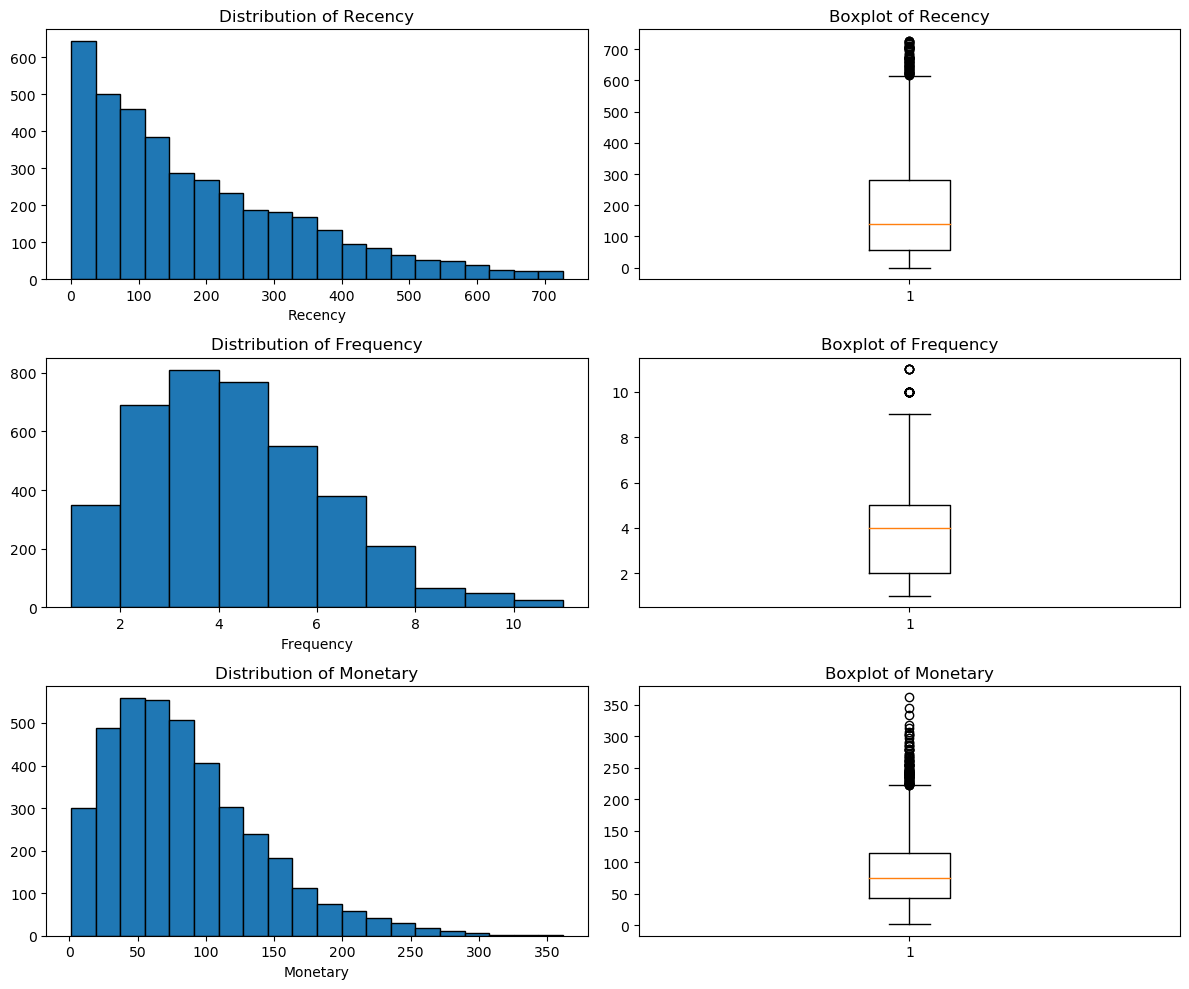

In [31]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Histogram
axs[0, 0].hist(df_RFM['Recency'], bins=20, edgecolor='black')
axs[0, 0].set_title('Distribution of Recency')
axs[0, 0].set_xlabel('Recency')

axs[1, 0].hist(df_RFM['Frequency'], bins=10, edgecolor='black')
axs[1, 0].set_title('Distribution of Frequency')
axs[1, 0].set_xlabel('Frequency')

axs[2, 0].hist(df_RFM['Monetary'], bins=20, edgecolor='black')
axs[2, 0].set_title('Distribution of Monetary')
axs[2, 0].set_xlabel('Monetary')

# Boxplot
axs[0, 1].boxplot(df_RFM['Recency'])
axs[0, 1].set_title('Boxplot of Recency')

axs[1, 1].boxplot(df_RFM['Frequency'])
axs[1, 1].set_title('Boxplot of Frequency')

axs[2, 1].boxplot(df_RFM['Monetary'])
axs[2, 1].set_title('Boxplot of Monetary')

plt.tight_layout()
plt.show()

- Recency : Biểu đồ lệch phải, phần lớn khách hàng đã mua hàng 5 tháng gần đây, và số lượng khách hàng giảm dần khi thời gian mua hàng càng xa
- Frequency : Biểu đồ cho thấy phân phối gần như chuẩn, với đỉnh tập trung ở khoảng 2-6 lần mua hàng
- Monetary : Biểu đồ lệch phải, phần lớn khách hàng chi dưới 100$, và số lượng khách hàng chi nhiều hơn sẽ giảm dần.

#### Scale RFM

In [52]:
scaler=RobustScaler()
df_RFM_scaled = pd.DataFrame(scaler.fit_transform(df_RFM), columns=df_RFM.columns)
df_RFM_scaled.head()

Recency  Frequency  Monetary
0 -0.224215   2.333333  4.015055
1 -0.515695   2.000000  3.786079
2 -0.614350   2.000000  3.632729
3 -0.618834   1.000000  3.389889
4  0.004484   1.000000  3.328969

#### Remove outliers RFM

In [41]:
def remove_outliers (df, column_name, lower_percentile=0.25, upper_percentile=0.75, threshold=1.5):
  Q1=df[column_name].quantile(lower_percentile)
  Q3=df[column_name].quantile(upper_percentile)
  IQR=Q3-Q1
  lower_bound=Q1-threshold*IQR
  upper_bound=Q3+threshold*IQR
  df_clean=df.drop(index=df[(df[column_name]<lower_bound) | (df[column_name]>upper_bound)].index)
  return df_clean

df_RFM_clean = df_RFM.copy()

for col in df_RFM.columns:
    df_RFM_clean = remove_outliers(df_RFM_clean, col)

df_RFM_clean.shape

(3713, 3)

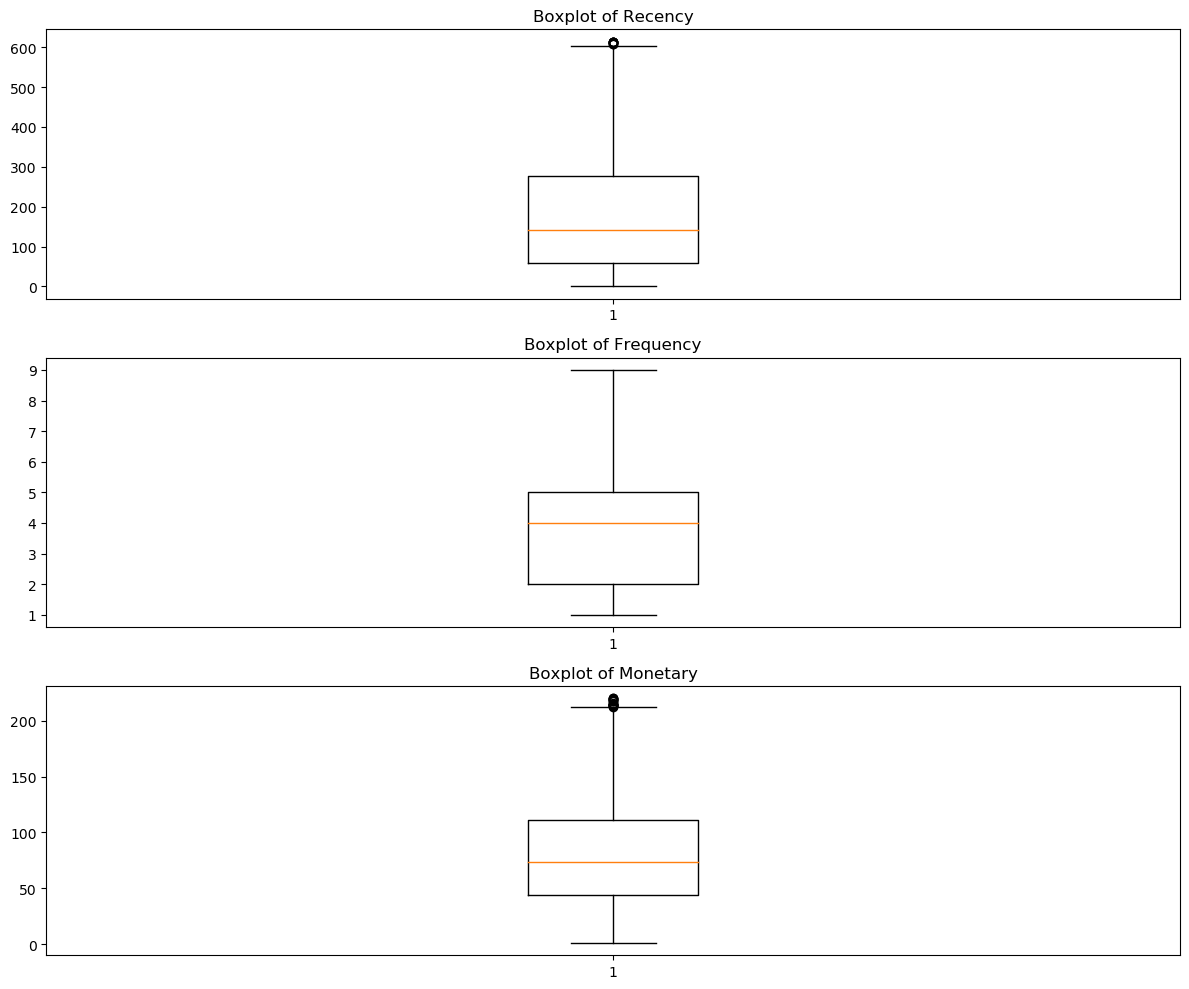

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Boxplot
axs[0].boxplot(df_RFM_clean['Recency'])
axs[0].set_title('Boxplot of Recency')

axs[1].boxplot(df_RFM_clean['Frequency'])
axs[1].set_title('Boxplot of Frequency')

axs[2].boxplot(df_RFM_clean['Monetary'])
axs[2].set_title('Boxplot of Monetary')

plt.tight_layout()
plt.show()

### Calculate RFM quintiles

In [ ]:
# Create labels for Recency, Frequency, Monetary
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

# Assign these labels to 5 equal percentile groups
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=5, labels=r_labels)
f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=5, labels=f_labels)
m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=5, labels=m_labels)

# Create new columns R, F, M
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head()

Recency  Frequency  Monetary  R  F  M
Member_number                                       
2193                91         11    361.45  4  5  5
1793                26         10    345.10  5  5  5
3289                 4         10    334.15  5  5  5
2433                 3          7    316.81  5  5  5
2743               142          7    312.46  3  5  5

### Concat RFM quintile values to create RFM Segments

In [ ]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)
df_RFM.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment
Member_number                                                   
2193                91         11    361.45  4  5  5         455
1793                26         10    345.10  5  5  5         555
3289                 4         10    334.15  5  5  5         555
2433                 3          7    316.81  5  5  5         555
2743               142          7    312.46  3  5  5         355

### Count number of unique segments

In [ ]:
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()
print(rfm_count_unique.sum())

120


- Phương pháp Concatenate cho ra 120 phân khúc khách hàng khác nhau, không khả thi nên cần tìm cách tiếp cận khác

### Calculate RFM score and level

In [ ]:
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
Member_number                                                              
2193                91         11    361.45  4  5  5         455         14
1793                26         10    345.10  5  5  5         555         15
3289                 4         10    334.15  5  5  5         555         15
2433                 3          7    316.81  5  5  5         555         15
2743               142          7    312.46  3  5  5         355         13

## Manual Segmentation

In [ ]:
def rfm_level(df):
    if df['RFM_Score'] >= 14:
        return 'HARDCORE'
    elif df['R'] >= 4 and df['F'] == 1 and df['M'] == 1:
        return 'NEW'
    elif df['RFM_Score'] >= 10:
        return 'LOYAL'
    elif df['RFM_Score'] >= 7:
        return 'POTENTIAL'
    elif df['RFM_Score'] >= 5:
        return 'AT RISK'
    else:
        return 'LOST'

In [ ]:
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)
df_RFM.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score  \
Member_number                                                                 
2193                91         11    361.45  4  5  5         455         14   
1793                26         10    345.10  5  5  5         555         15   
3289                 4         10    334.15  5  5  5         555         15   
2433                 3          7    316.81  5  5  5         555         15   
2743               142          7    312.46  3  5  5         355         13   

              RFM_Level  
Member_number            
2193           HARDCORE  
1793           HARDCORE  
3289           HARDCORE  
2433           HARDCORE  
2743              LOYAL

In [ ]:
df_RFM['RFM_Level'].value_counts()

RFM_Level
LOYAL        1355
POTENTIAL    1053
AT RISK       563
LOST          448
HARDCORE      431
NEW            48
Name: count, dtype: int64

#### Calculate mean values for each segment

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({'Recency': 'mean',
                                           'Frequency': 'mean',
                                           'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()
rfm_agg

RFM_Level  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0    AT RISK        293.0            2.0          45.0    563    14.44
1   HARDCORE         39.0            7.0         171.0    431    11.06
2       LOST        454.0            1.0          24.0    448    11.49
3      LOYAL        106.0            5.0         110.0   1355    34.76
4        NEW         41.0            1.0          20.0     48     1.23
5  POTENTIAL        191.0            3.0          67.0   1053    27.01

#### TreeMap

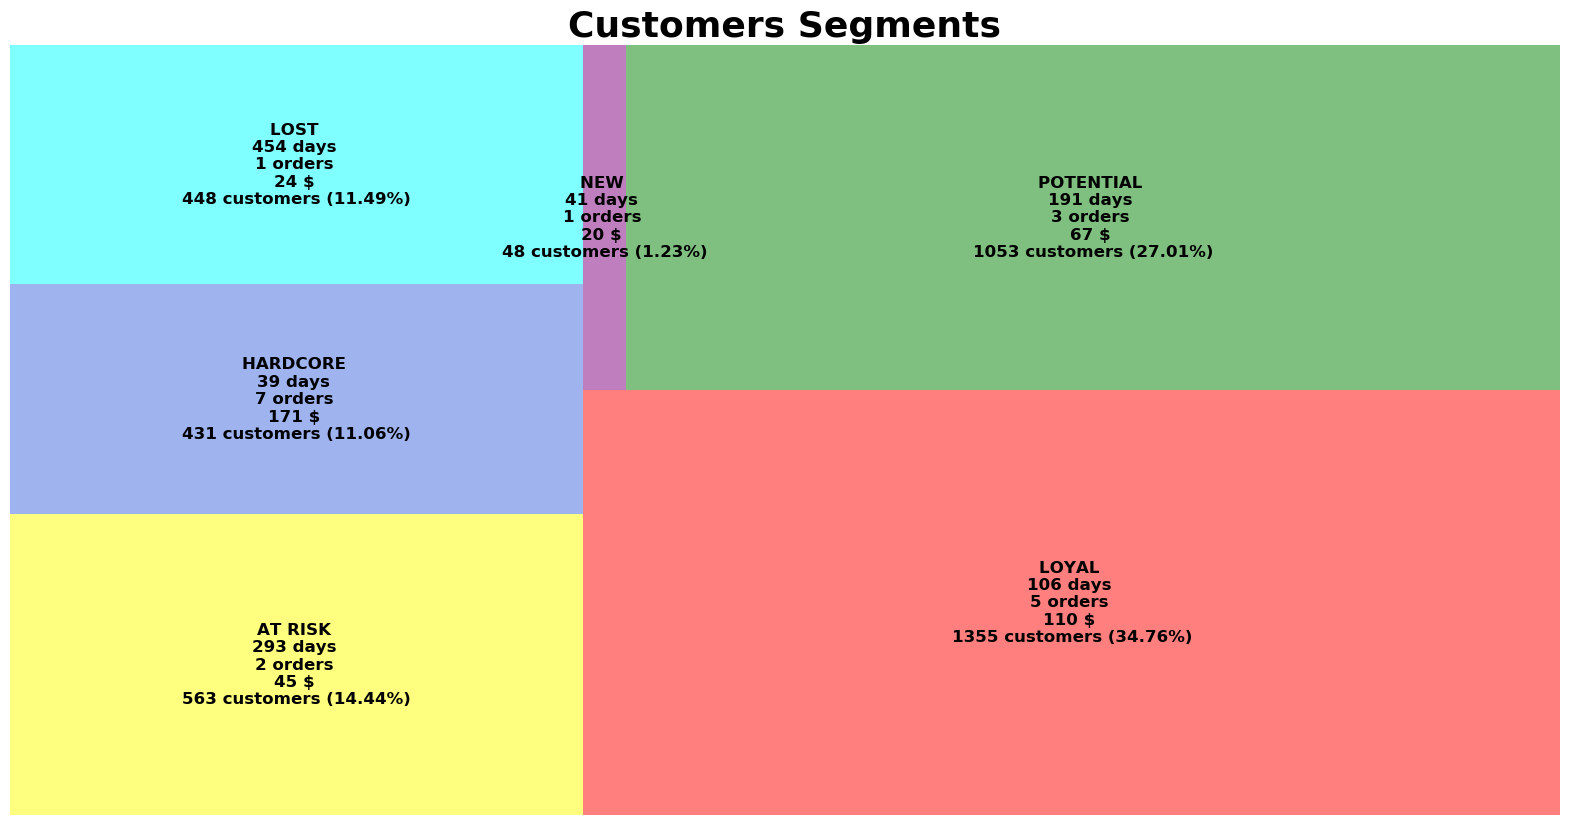

In [ ]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 10)

colors_dict = {'AT RISK':'yellow','HARDCORE':'royalblue', 'LOST':'cyan',
               'LOYAL':'red', 'NEW':'purple', 'POTENTIAL':'green'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

#### Scatter Plot

In [ ]:
fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max=100)
fig.show()

- Hardcore (chiếm 11%) : Là nhóm khách hàng hoạt động tích cực nhất, với tần suất mua sắm cao nhất (trung bình 7 lần), tổng chi tiêu lớn nhất (171$) và lần mua gần nhất chỉ cách thời gian ghi nhận dữ liệu 1 tháng.
- Loyal (chiếm 35%) : Là nhóm khách hàng trung thành, với tần suất mua sắm cao (trung bình 5 lần), tổng chi tiêu lớn (100) và lần mua gần nhất cách thời gian ghi nhận dữ liệu là hơn 3 tháng.
- Potential (chiếm 27%) : Là nhóm khách hàng tiềm năng, với tần suất mua trung bình 3 lần, tổng chi tiêu trung bình 67 và lần mua gần nhất cách thời gian ghi nhận dữ liệu là hơn 6 tháng.
- At Risk (chiếm 14%) : Là nhóm khách hàng có nguy cơ không mua hàng nữa, với tần suất mua thấp (chỉ 2 lần), tổng chi tiêu thấp (45) và lần mua gần nhất cách thời gian ghi nhận dữ liệu là tầm 10 tháng.
- Lost (chiếm 12%) : Là nhóm khách hàng không có tiềm năng quay lại mua hàng, với chỉ 1 lần mua hàng nhưng cách thời gian ghi nhận dữ liệu là hơn 15 tháng, tổng chi tiêu thấp (24)
- New (chiếm 1%) : Là nhóm khách hàng mới mua hàng lần đầu tiên tại cửa hàng trong vòng tầm 1 tháng đổ lại.

In [ ]:
sil_manual=silhouette_score(df_RFM[["Recency", "Monetary", "Frequency"]].values, df_RFM['RFM_Level'], metric = 'euclidean')
print("Độ đo Silhoutte Score của Manual Segmentation :", sil_manual)

Độ đo Silhoutte Score của Manual Segmentation : -0.05916331956014113


## RFM + KMeans

#### Original data

In [70]:
df_kmeans = df_RFM[['Recency','Frequency','Monetary']]
df_kmeans.head()

Recency  Frequency  Monetary
Member_number                              
2193                91         11    361.45
1793                26         10    345.10
3289                 4         10    334.15
2433                 3          7    316.81
2743               142          7    312.46

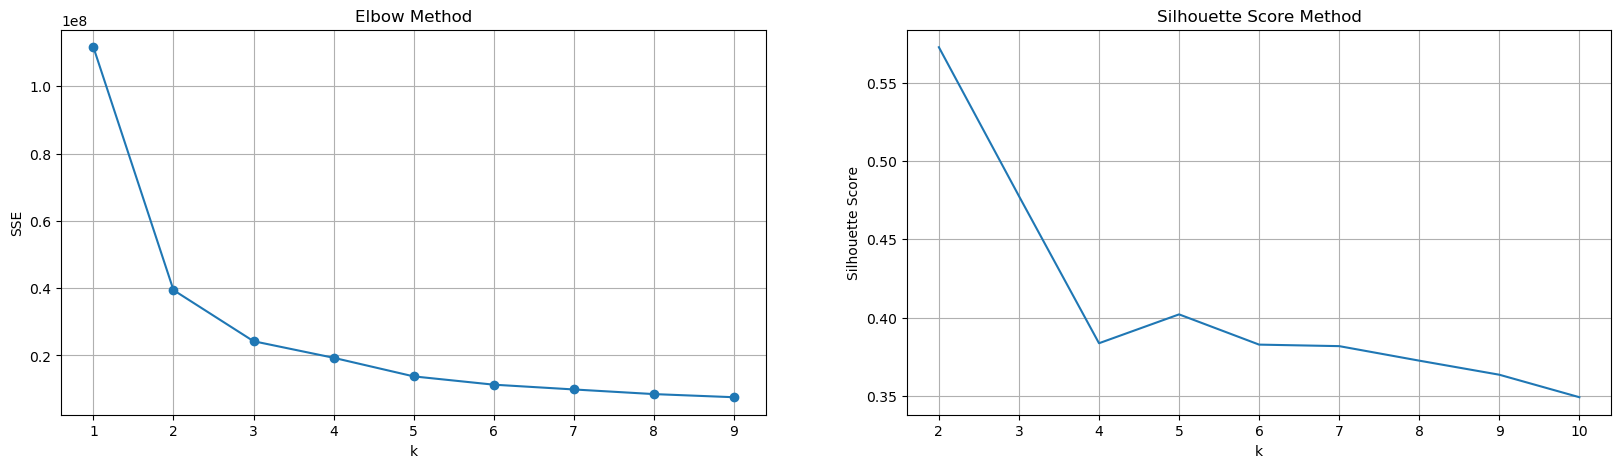

In [ ]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_kmeans)
    sse[k] = kmeans.inertia_

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.title('Elbow Method')
plt.xlabel("k")
plt.ylabel("SSE")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_kmeans)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_kmeans, labels, metric = 'euclidean'))
plt.plot(range(2,kmax + 1), sil);
plt.title('Silhouette Score Method')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

##### TH1: Chọn k=2 theo (Elbow method) và độ đo Sihoutte cao nhất

In [ ]:
# Build model with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_kmeans)
kmeans.labels_.shape

(3898,)

In [ ]:
df_kmeans["Cluster"] = kmeans.labels_
df_kmeans.groupby('Cluster').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean', 'count']}).round(2)

<ipython-input-146-90743f60311e>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        395.73      2.72    56.26  1153
1        100.32      4.31    96.93  2745

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df_kmeans.groupby('Cluster').agg({'Recency': 'mean',
                                             'Frequency': 'mean',
                                             'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0        396.0            3.0          56.0   1153    29.58
1  Cluster 1        100.0            4.0          97.0   2745    70.42

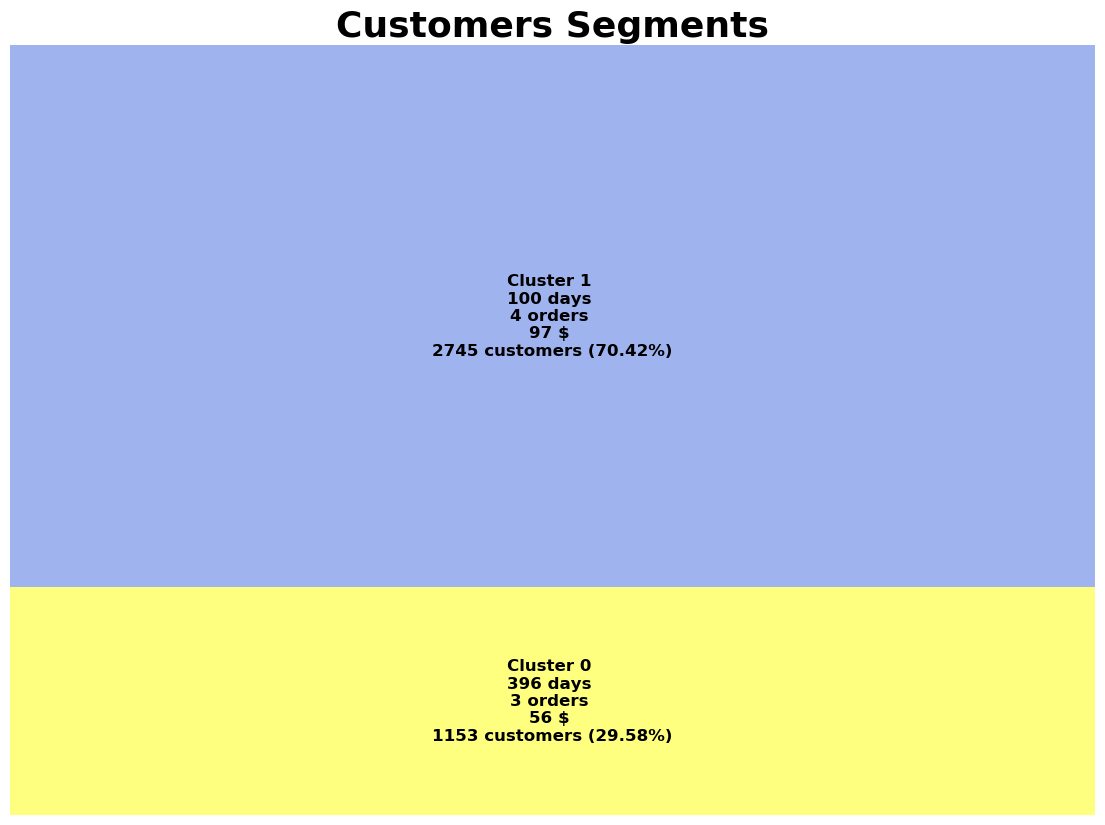

In [ ]:
# Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
# Scatter plot
fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

- Cluster 1 (chiếm 70%) : với tần suất mua sắm trung bình 6 lần, chi tiêu lớn (97) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 3 tháng => Là nhóm khách hàng trung thành và hoạt động tích cực nhất
- Cluster 0 (chiếm 30%) : với chỉ 3 lần mua hàng nhưng cách thời gian ghi nhận dữ liệu là hơn 1 năm, chi tiêu thấp (56) => Là nhóm khách hàng có mức độ tương tác rất thấp, đã không mua hàng trong một thời gian dài và cũng không chi tiêu nhiều.

In [ ]:
sil_kmeans=silhouette_score(df_kmeans[["Recency", "Monetary", "Frequency"]].values, kmeans.labels_, metric = 'euclidean')
print("Độ đo Silhoutte Score của KMeanns:", sil_kmeans)

Độ đo Silhoutte Score của KMeanns: 0.5729328376442179


2 cụm sẽ không phản ánh được đặc điểm của khách hàng, nên chia nhiều cụm hơn

##### TH2: k=5 vì tại đó chỉ số SSE bắt đầu chậm lại đáng kể và độ đo Sihoutte vẫn khá tốt

In [71]:
# Build model with k=5
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_kmeans)
kmeans.labels_.shape

(3898,)

In [72]:
df_kmeans["Cluster"] = kmeans.labels_
df_kmeans.groupby('Cluster').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        191.62      3.69    78.39  1077
1        560.04      1.93    37.18   301
2         63.46      6.15   175.56   601
3         55.27      3.82    71.35  1204
4        352.49      2.94    61.39   715

In [73]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df_kmeans.groupby('Cluster').agg({'Recency': 'mean',
                                             'Frequency': 'mean',
                                             'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0        192.0            4.0          78.0   1077    27.63
1  Cluster 1        560.0            2.0          37.0    301     7.72
2  Cluster 2         63.0            6.0         176.0    601    15.42
3  Cluster 3         55.0            4.0          71.0   1204    30.89
4  Cluster 4        352.0            3.0          61.0    715    18.34

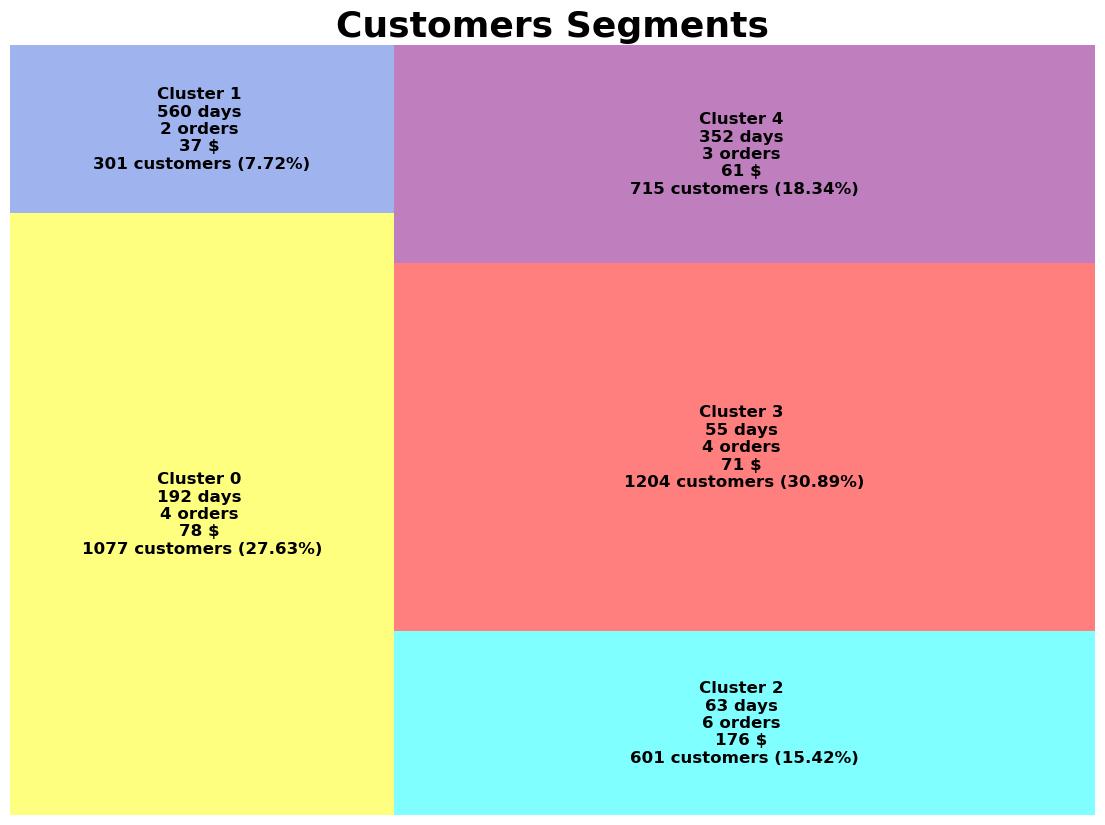

In [74]:
# Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [75]:
# Scatter plot
fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

In [76]:
sil_kmeans=silhouette_score(df_kmeans[["Recency", "Monetary", "Frequency"]].values, kmeans.labels_, metric = 'euclidean')
print("Độ đo Silhoutte Score của KMeanns (5 cụm):", sil_kmeans)

Độ đo Silhoutte Score của KMeanns (5 cụm): 0.40201931399947916


- Cluster 2 (chiếm 15%) : với tần suất mua sắm trung bình 6 lần, chi tiêu lớn nhất (176) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 2 tháng => Là nhóm khách hàng mang lại doanh thu lớn nhất cho cửa hàng khi mua hàng thường xuyên và chi tiêu rất nhiều (HARDCORE)
- Cluster 3 (chiếm 31%) : với tần suất mua sắm trung bình 4 lần, chi tiêu lớn (71) và lần mua gần nhất cách thời gian ghi nhận dữ liệu dưới 2 tháng => Là nhóm khách hàng mua hàng thường xuyên (LOYAL)
- Cluster 0 (chiếm 28%) : với tần suất mua sắm trung bình 4 lần, chi tiêu trung bình (78) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 6 tháng => Là nhóm khách hàng tiềm năng (POTENTIAL)
- Cluster 4 (chiếm 18%) : với tần suất mua sắm trung bình 3 lần, chi tiêu thấp (61) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 1 năm => Là nhóm khách hàng có nguy cơ rời bỏ cửa hàng khi đã lâu không mua hàng và giá trị mua hàng cũng không cao (AT RISK)
- Cluster 3 (chiếm 8%) : với tần suất mua sắm trung bình 2 lần, chi tiêu rất thấp (37) và lần mua gần nhất cách thời gian ghi nhận dữ liệu hơn 1.5 năm => Là nhóm khách hàng không còn tương tác với cửa hàng và giá trị mua hàng rất thấp (LOST)

#### Scale data

In [134]:
df_kmeans_scaled = df_RFM_scaled.copy()

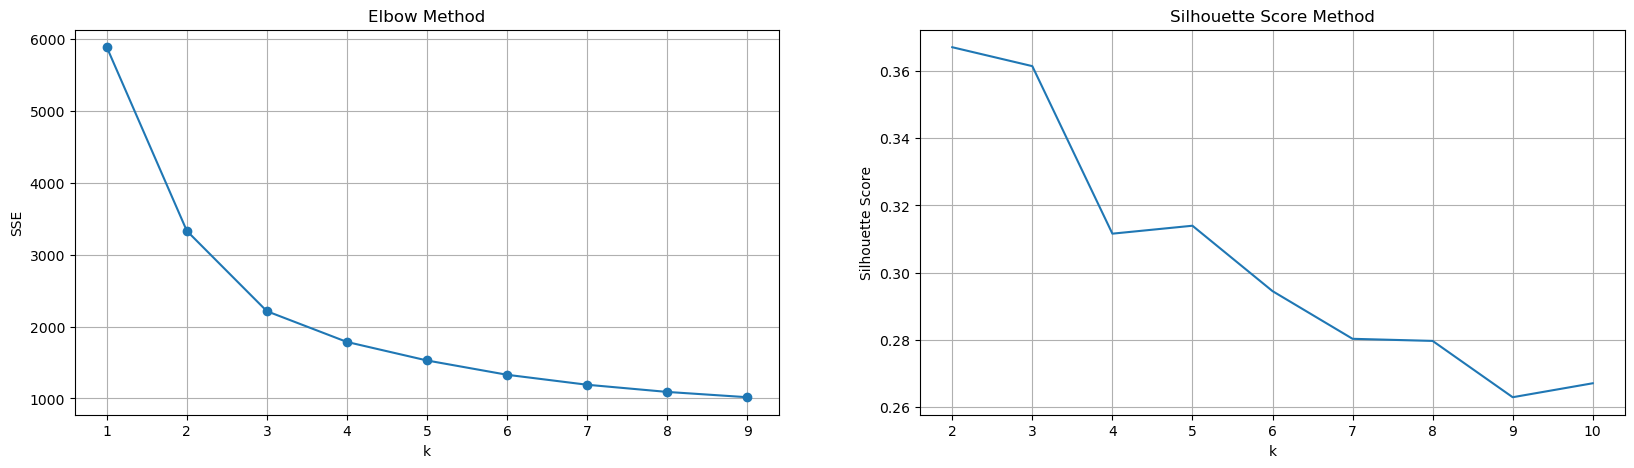

In [135]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_kmeans_scaled)
    sse[k] = kmeans.inertia_

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.title('Elbow Method')
plt.xlabel("k")
plt.ylabel("SSE")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_kmeans_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_kmeans_scaled, labels, metric = 'euclidean'))
plt.plot(range(2,kmax + 1), sil);
plt.title('Silhouette Score Method')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

In [136]:
# Build model with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_kmeans_scaled)

df_kmeans_scaled["Cluster"] = kmeans.labels_
df_kmeans_scaled.groupby('Cluster').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean', 'count']}).round(2)

# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2_scaled = df_kmeans_scaled.groupby('Cluster').agg({'Recency': 'mean',
                                             'Frequency': 'mean',
                                             'Monetary': ['mean', 'count']}).round(0)

rfm_agg2_scaled.columns = rfm_agg2_scaled.columns.droplevel()
rfm_agg2_scaled.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2_scaled['Percent'] = round((rfm_agg2_scaled['Count']/rfm_agg2_scaled.Count.sum())*100, 2)

# Reset the index
rfm_agg2_scaled = rfm_agg2_scaled.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2_scaled['Cluster'] = 'Cluster '+ rfm_agg2_scaled['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2_scaled

Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0         -0.0           -0.0          -0.0   1854    47.56
1  Cluster 1          1.0           -1.0          -0.0    973    24.96
2  Cluster 2         -0.0            1.0           1.0   1071    27.48

In [137]:
rfm_agg2_scaled[['RecencyMean', 'FrequencyMean',	'MonetaryMean']]=scaler.inverse_transform(rfm_agg2_scaled[['RecencyMean', 'FrequencyMean',	'MonetaryMean']])
rfm_agg2_scaled

Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0        141.0            4.0        74.755   1854    47.56
1  Cluster 1        364.0            1.0        74.755    973    24.96
2  Cluster 2        141.0            7.0       146.160   1071    27.48

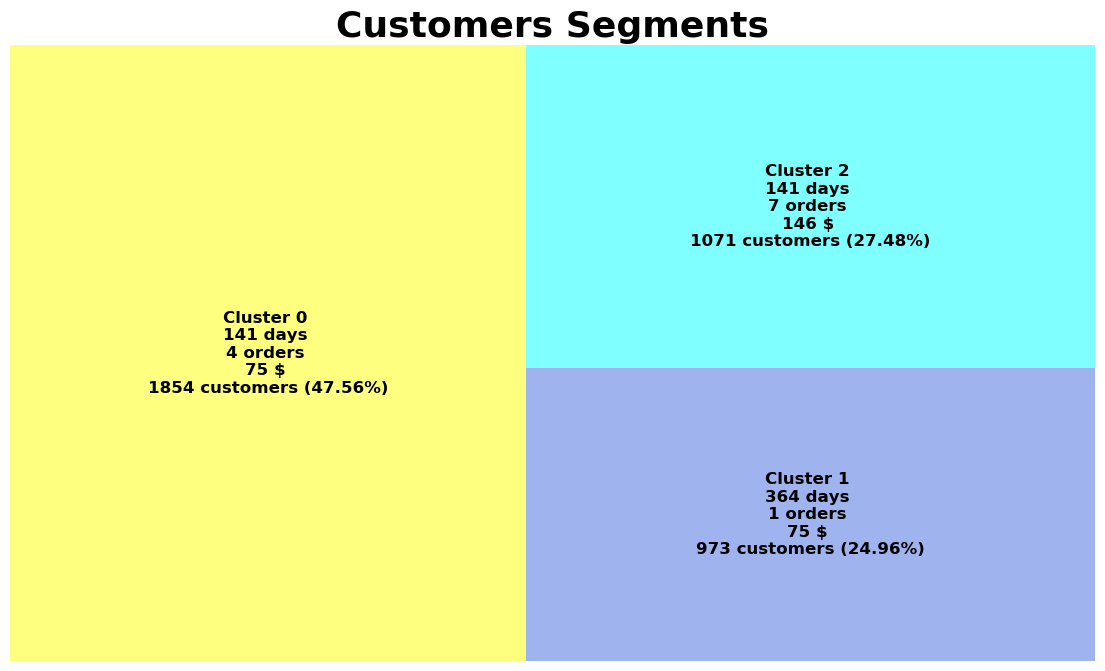

In [138]:
# Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 8)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan'}

squarify.plot(sizes=rfm_agg2_scaled['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2_scaled.iloc[i])
                      for i in range(0, len(rfm_agg2_scaled))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [139]:
# Scatter plot
fig = px.scatter(rfm_agg2_scaled, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

In [141]:
sil_kmeans=silhouette_score(df_kmeans_scaled[["Recency", "Monetary", "Frequency"]].values, kmeans.labels_, metric = 'euclidean')
print("Độ đo Silhoutte Score của KMeanns đã scale data (3 cụm):", sil_kmeans)

Độ đo Silhoutte Score của KMeanns đã scale data (3 cụm): 0.3614052751573513


#### Remove outliers data

In [45]:
df_kmeans_clean = df_RFM_clean.copy()

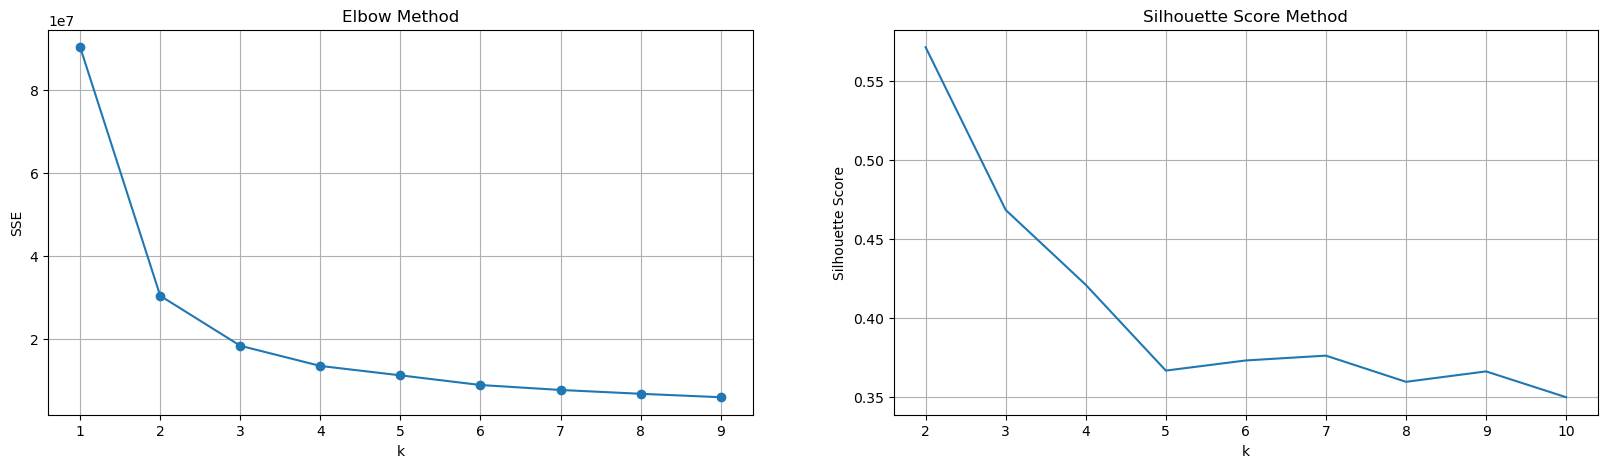

In [46]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_kmeans_clean)
    sse[k] = kmeans.inertia_

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.title('Elbow Method')
plt.xlabel("k")
plt.ylabel("SSE")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_kmeans_clean)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_kmeans_clean, labels, metric = 'euclidean'))
plt.plot(range(2,kmax + 1), sil);
plt.title('Silhouette Score Method')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

In [81]:
# Build model with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_kmeans_clean)

df_kmeans_clean["Cluster"] = kmeans.labels_
df_kmeans_clean.groupby('Cluster').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'Monetary':['mean', 'count']}).round(2)

# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2_clean = df_kmeans_clean.groupby('Cluster').agg({'Recency': 'mean',
                                             'Frequency': 'mean',
                                             'Monetary': ['mean', 'count']}).round(0)

rfm_agg2_clean.columns = rfm_agg2_clean.columns.droplevel()
rfm_agg2_clean.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2_clean['Percent'] = round((rfm_agg2_clean['Count']/rfm_agg2_clean.Count.sum())*100, 2)

# Reset the index
rfm_agg2_clean = rfm_agg2_clean.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2_clean['Cluster'] = 'Cluster '+ rfm_agg2_clean['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2_clean

Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0         50.0            4.0          97.0   1531    41.23
1  Cluster 1        492.0            2.0          43.0    368     9.91
2  Cluster 2        320.0            3.0          65.0    720    19.39
3  Cluster 3        172.0            4.0          81.0   1094    29.46

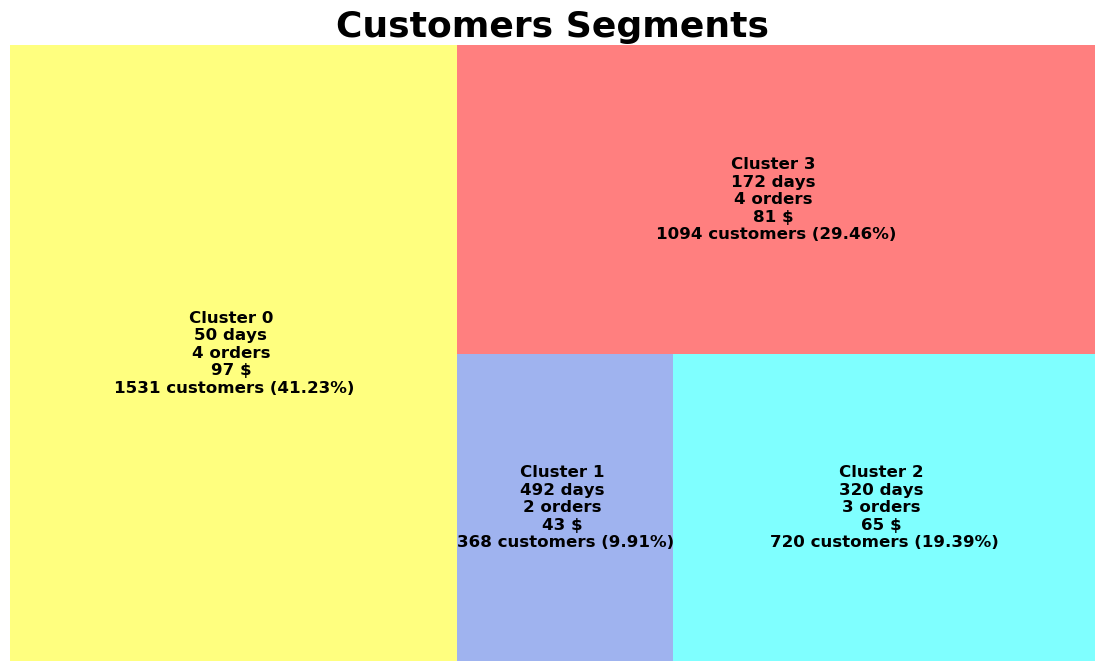

In [87]:
# Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 8)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red'}

squarify.plot(sizes=rfm_agg2_clean['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2_clean.iloc[i])
                      for i in range(0, len(rfm_agg2_clean))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [82]:
# Scatter plot
fig = px.scatter(rfm_agg2_clean, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

In [83]:
sil_kmeans=silhouette_score(df_kmeans_clean[["Recency", "Monetary", "Frequency"]].values, kmeans.labels_, metric = 'euclidean')
print("Độ đo Silhoutte Score của KMeanns đã remove outliers (4 cụm):", sil_kmeans)

Độ đo Silhoutte Score của KMeanns đã remove outliers (4 cụm): 0.42110370796715607


## RFM + GMM

#### Original data

In [ ]:
df_gmm = df_RFM[['Recency','Frequency','Monetary']]
df_gmm.head()

Recency  Frequency  Monetary
Member_number                              
2193                91         11    361.45
1793                26         10    345.10
3289                 4         10    334.15
2433                 3          7    316.81
2743               142          7    312.46

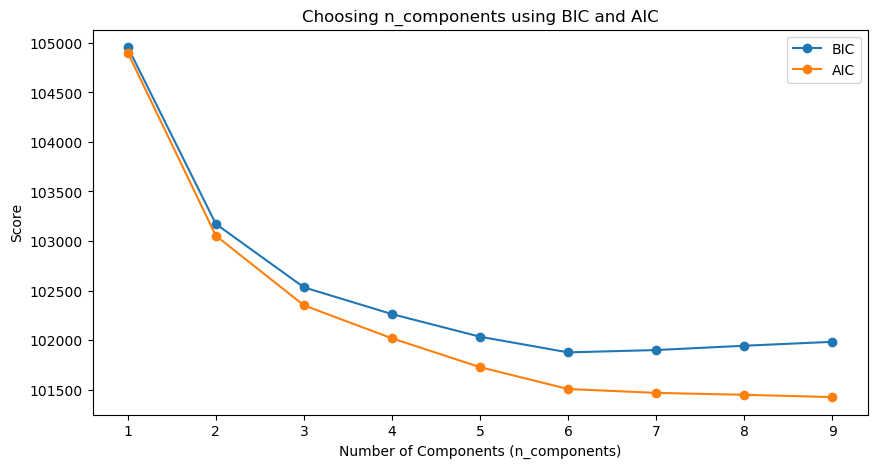

In [ ]:
# Try different n_components
n_components_range = range(1, 10)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df_gmm)
    bic_scores.append(gmm.bic(df_gmm))
    aic_scores.append(gmm.aic(df_gmm))

# Plot BIC & AIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Score")
plt.legend()
plt.title("Choosing n_components using BIC and AIC")
plt.show()

In [ ]:
# Choose n_components = 6, where BIC is the smallest and AIC starts decreasing more slowly
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(df_gmm)

GaussianMixture(n_components=6, random_state=42)

In [ ]:
labels = gmm.predict(df_gmm)
labels

array([2, 2, 2, ..., 1, 1, 3])

In [ ]:
gmm.weights_

array([0.14251317, 0.12298658, 0.15320646, 0.1836719 , 0.17882697,
       0.21879492])

In [ ]:
gmm.means_

array([[240.79007209,   4.5577033 , 116.01088328],
       [386.32832393,   1.59641942,  20.67486111],
       [ 86.49150878,   5.81898353, 155.35238381],
       [ 29.9314051 ,   4.58349428,  96.07579719],
       [338.71141019,   2.91114444,  57.80335977],
       [121.36058484,   3.37671536,  64.15738446]])

In [ ]:
gmm.feature_names_in_

array(['Recency', 'Frequency', 'Monetary'], dtype=object)

In [ ]:
rfm_agg3=pd.DataFrame((gmm.means_).round().astype(int), columns=gmm.feature_names_in_)
rfm_agg3.columns = ['RecencyMean','FrequencyMean','MonetaryMean']

rfm_agg3.insert(0, 'Cluster', ['Cluster ' + str(i) for i in range(len(gmm.means_))])

rfm_agg3['Count'] = (gmm.weights_ * df_gmm.shape[0]).round().astype(int)

rfm_agg3['Percent'] = (gmm.weights_*100).round(2)

rfm_agg3

Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0          241              5           116    556    14.25
1  Cluster 1          386              2            21    479    12.30
2  Cluster 2           86              6           155    597    15.32
3  Cluster 3           30              5            96    716    18.37
4  Cluster 4          339              3            58    697    17.88
5  Cluster 5          121              3            64    853    21.88

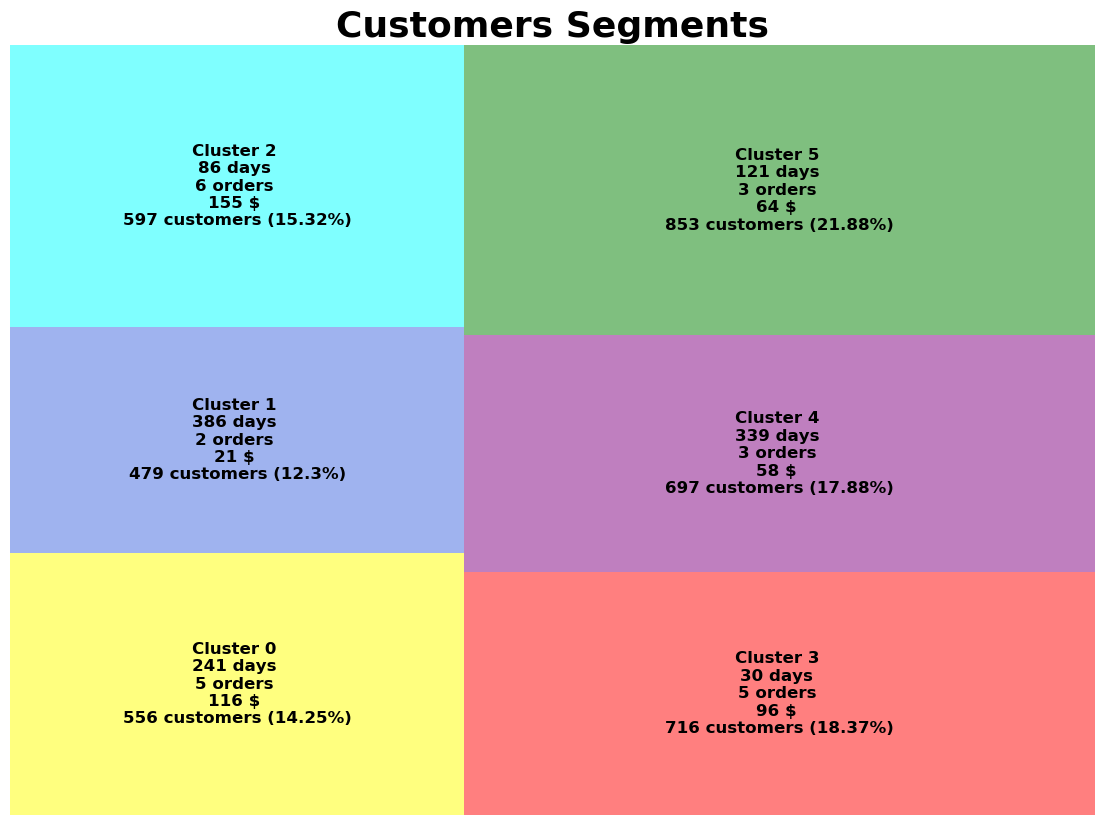

In [ ]:
# Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict3 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green'}

squarify.plot(sizes=rfm_agg3['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict3.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg3.iloc[i])
                      for i in range(0, len(rfm_agg3))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
# Scatter plot
fig = px.scatter(rfm_agg3, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

- Cluster 0 (chiếm 15%) : với tần suất mua sắm trung bình 6 lần, chi tiêu lớn nhất (155) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 3 tháng => Là nhóm khách hàng mang lại doanh thu lớn nhất cho cửa hàng khi mua hàng thường xuyên và chi tiêu rất nhiều (HARDCORE)
- Cluster 2 (chiếm 19%) : với tần suất mua sắm trung bình 5 lần, chi tiêu lớn (96) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 1 tháng => Là nhóm khách hàng có giá trị cao khi mua hàng thường xuyên, chi tiêu nhiều (LOYAL)
- Cluster 4 (chiếm 23%) : với tần suất mua sắm trung bình 3 lần, chi tiêu trung bình (65) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 4 tháng => Là nhóm khách hàng tiềm năng (POTENTIAL)
- Cluster 1 (chiếm 14%) : với tần suất mua sắm trung bình 5 lần, chi tiêu cao (114) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 8 tháng => Là nhóm khách hàng trung thành nhưng có nguy cơ rời bỏ, với tần suất mua hàng và chi tiêu cao, tuy nhiên đã lâu không quay lại cửa hàng (AT-RISK LOYAL)
- Cluster 5 (chiếm 17%) : với tần suất mua sắm trung bình 3 lần, chi tiêu thấp (55) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 11 tháng => Là nhóm khách hàng có nguy cơ rời bỏ cửa hàng khi đã lâu không mua hàng và giá trị mua hàng cũng không cao (AT RISK)
- Cluster 3 (chiếm 12%) : với tần suất mua sắm trung bình 2 lần, chi tiêu rất thấp (20) và lần mua gần nhất cách thời gian ghi nhận dữ liệu hơn 1 năm => Là nhóm khách hàng không còn tương tác với cửa hàng và giá trị mua hàng rất thấp (LOST)

In [ ]:
sil_gmm=silhouette_score(df_gmm[["Recency", "Monetary", "Frequency"]].values, labels, metric = 'euclidean')
print("Độ đo Silhoutte Score của GMM:", sil_gmm)

Độ đo Silhoutte Score của GMM: 0.20105692152154173


#### Scale data

In [161]:
df_gmm_scaled = df_RFM_scaled.copy()

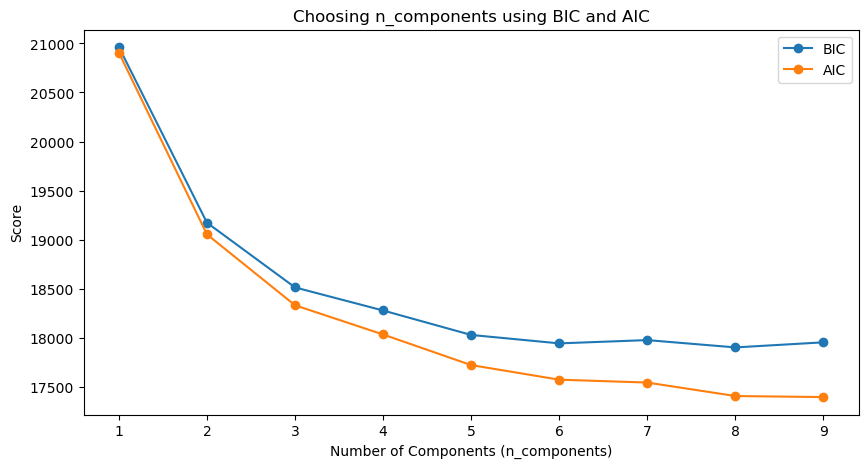

In [162]:
# Try different n_components
n_components_range = range(1, 10)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df_gmm_scaled)
    bic_scores.append(gmm.bic(df_gmm_scaled))
    aic_scores.append(gmm.aic(df_gmm_scaled))

# Plot BIC & AIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Score")
plt.legend()
plt.title("Choosing n_components using BIC and AIC")
plt.show()

In [178]:
# Choose n_components = 6, where BIC is the smallest and AIC starts decreasing more slowly
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(df_gmm_scaled)

GaussianMixture(n_components=6, random_state=42)

In [179]:
rfm_agg3_scaled=pd.DataFrame((gmm.means_).round().astype(int), columns=gmm.feature_names_in_)
rfm_agg3_scaled.columns = ['RecencyMean','FrequencyMean','MonetaryMean']

rfm_agg3_scaled.insert(0, 'Cluster', ['Cluster ' + str(i) for i in range(len(gmm.means_))])

rfm_agg3_scaled['Count'] = (gmm.weights_ * df_gmm_scaled.shape[0]).round().astype(int)

rfm_agg3_scaled['Percent'] = (gmm.weights_*100).round(2)

rfm_agg3_scaled[['RecencyMean', 'FrequencyMean',	'MonetaryMean']]=scaler.inverse_transform(rfm_agg3_scaled[['RecencyMean', 'FrequencyMean',	'MonetaryMean']])

rfm_agg3_scaled

Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0        364.0            4.0        74.755    982    25.19
1  Cluster 1        141.0            4.0        74.755    666    17.07
2  Cluster 2        141.0            7.0       146.160    380     9.74
3  Cluster 3        364.0            1.0         3.350    535    13.72
4  Cluster 4        141.0            4.0        74.755    726    18.63
5  Cluster 5        141.0            4.0       146.160    610    15.64

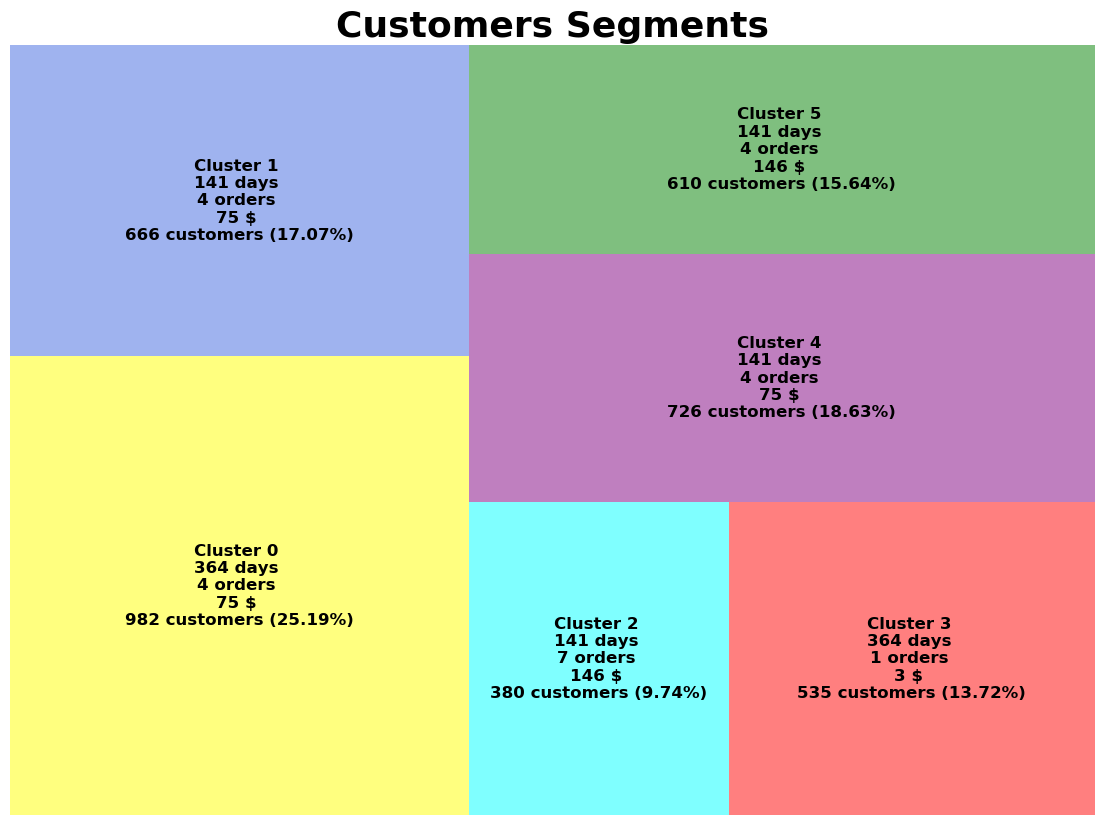

In [180]:
# Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict3 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green'}

squarify.plot(sizes=rfm_agg3_scaled['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict3.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg3_scaled.iloc[i])
                      for i in range(0, len(rfm_agg3_scaled))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [181]:
# Scatter plot
fig = px.scatter(rfm_agg3_scaled, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

In [182]:
sil_gmm=silhouette_score(df_gmm_scaled[["Recency", "Monetary", "Frequency"]].values, gmm.predict(df_gmm_scaled), metric = 'euclidean')
print("Độ đo Silhoutte Score của GMM khi đã scale data:", sil_gmm)

Độ đo Silhoutte Score của GMM khi đã scale data: 0.12660218209218557


#### Remove outliers data

In [183]:
df_gmm_clean = df_RFM_clean.copy()

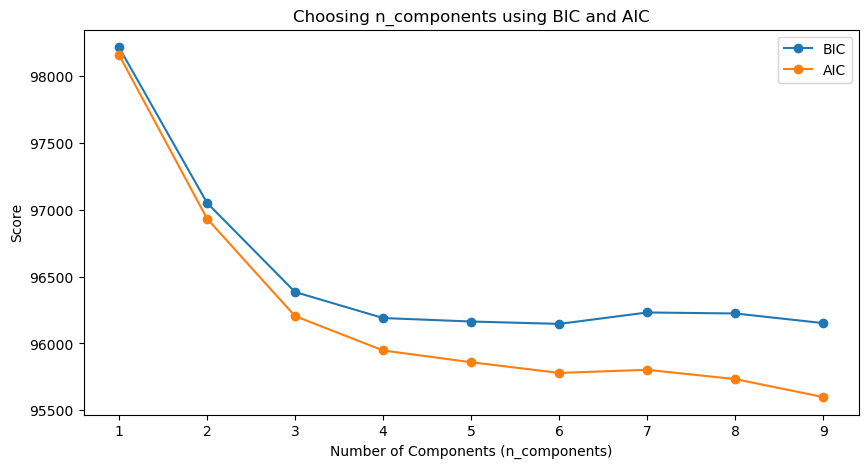

In [184]:
# Try different n_components
n_components_range = range(1, 10)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df_gmm_clean)
    bic_scores.append(gmm.bic(df_gmm_clean))
    aic_scores.append(gmm.aic(df_gmm_clean))

# Plot BIC & AIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Score")
plt.legend()
plt.title("Choosing n_components using BIC and AIC")
plt.show()

In [185]:
# Choose n_components = 4, where BIC is the smallest and AIC starts decreasing more slowly
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(df_gmm_clean)

GaussianMixture(n_components=4, random_state=42)

In [186]:
rfm_agg3_clean=pd.DataFrame((gmm.means_).round().astype(int), columns=gmm.feature_names_in_)
rfm_agg3_clean.columns = ['RecencyMean','FrequencyMean','MonetaryMean']

rfm_agg3_clean.insert(0, 'Cluster', ['Cluster ' + str(i) for i in range(len(gmm.means_))])

rfm_agg3_clean['Count'] = (gmm.weights_ * df_gmm_clean.shape[0]).round().astype(int)

rfm_agg3_clean['Percent'] = (gmm.weights_*100).round(2)

rfm_agg3_clean

Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0           38              5           106    969    26.08
1  Cluster 1          312              2            28    698    18.80
2  Cluster 2          298              3            70    829    22.33
3  Cluster 3          143              4            99   1217    32.78

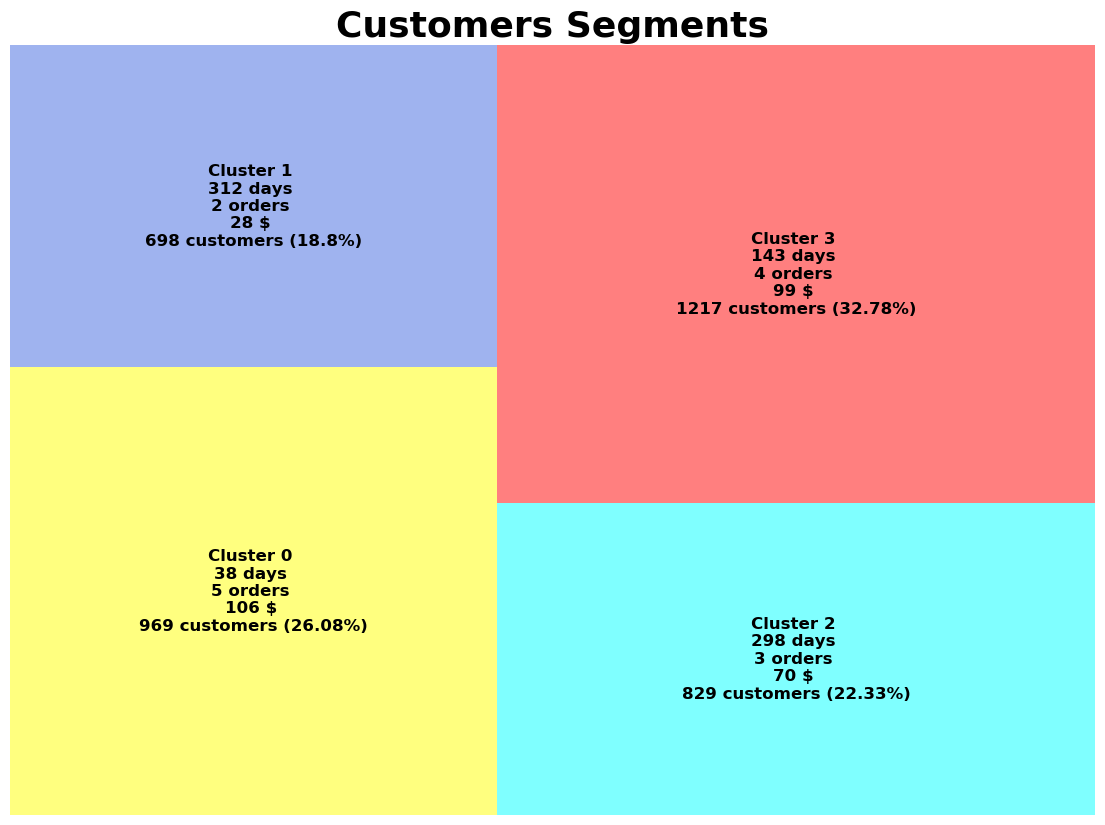

In [187]:
# Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict3 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red'}

squarify.plot(sizes=rfm_agg3_clean['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict3.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg3_clean.iloc[i])
                      for i in range(0, len(rfm_agg3_clean))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [188]:
# Scatter plot
fig = px.scatter(rfm_agg3_clean, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

In [189]:
sil_gmm=silhouette_score(df_gmm_clean[["Recency", "Monetary", "Frequency"]].values, gmm.predict(df_gmm_clean), metric = 'euclidean')
print("Độ đo Silhoutte Score của GMM khi đã remove outlier:", sil_gmm)

Độ đo Silhoutte Score của GMM khi đã remove outlier: 0.20041016583479063


## RFM + DBSCAN

#### Original data

In [ ]:
df_dbscan = df_RFM[['Recency','Frequency','Monetary']]
df_dbscan.head()

Recency  Frequency  Monetary
Member_number                              
2193                91         11    361.45
1793                26         10    345.10
3289                 4         10    334.15
2433                 3          7    316.81
2743               142          7    312.46

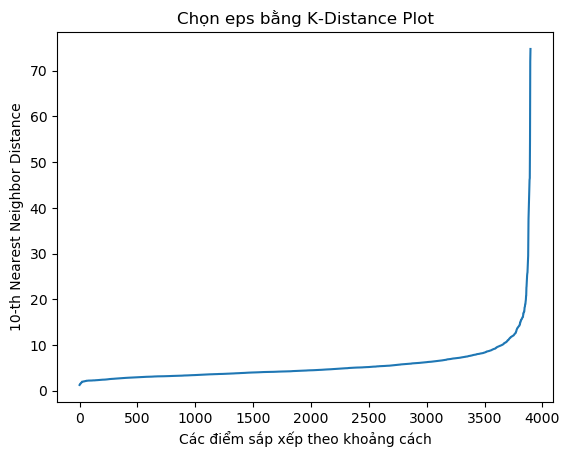

In [ ]:
# Choose eps value
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(df_dbscan)
distances, _ = neigh.kneighbors(df_dbscan)

# Sắp xếp khoảng cách theo thứ tự tăng dần
sorted_distances = np.sort(distances[:, -1])

# Vẽ biểu đồ K-Distance Plot
plt.plot(sorted_distances)
plt.xlabel("Các điểm sắp xếp theo khoảng cách")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("Chọn eps bằng K-Distance Plot")
plt.show()

In [ ]:
eps_values = np.arange(8,16, 0.5)
min_samples = np.arange(4,7)

dbscan_params = list(product(eps_values, min_samples))

num_of_clusters = []
sil_score = []

for p in dbscan_params:
    dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit(df_dbscan)
    num_of_clusters.append(len(np.unique(dbscan.labels_)))
    sil_score.append(silhouette_score(df_dbscan, dbscan.labels_))

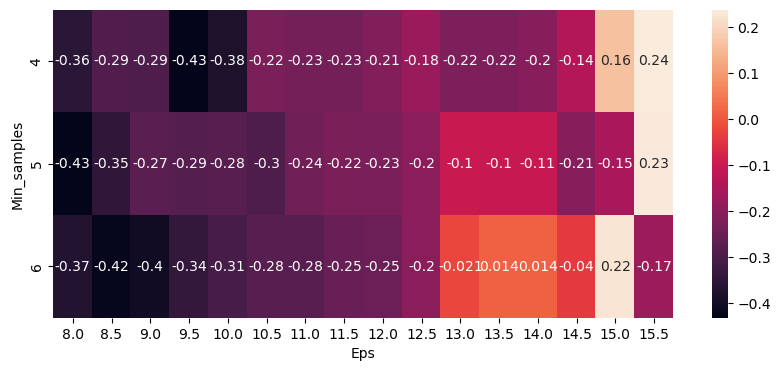

In [ ]:
tmp = pd.DataFrame.from_records(dbscan_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, ax=ax)
plt.show()

- Chọn eps và min_samples tại đó giá trị Sihoutte lớn nhất => eps=15.5, min_samples = 4



In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=15.5, min_samples=4)
labels = dbscan.fit_predict(df_dbscan)

# Count clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Estimated number of clusters: 2
Number of noise points: 53


In [ ]:
from collections import Counter

cluster_counts = Counter(labels)
for cluster_id, count in sorted(cluster_counts.items()):
    if cluster_id == -1:
        print(f"Nhiễu (-1): {count} điểm")
    else:
        print(f"Cụm {cluster_id}: {count} điểm")

Nhiễu (-1): 53 điểm
Cụm 0: 3839 điểm
Cụm 1: 6 điểm


In [ ]:
for cluster_id in set(labels):
    if cluster_id == -1:
        continue
    cluster_points = df_dbscan[labels == cluster_id]
    centroid = np.mean(cluster_points, axis=0)
    print(f"Tâm cụm {cluster_id}: {centroid}")

Tâm cụm 0: Recency      185.067465
Frequency      3.816098
Monetary      83.277627
dtype: float64
Tâm cụm 1: Recency      466.000000
Frequency      3.333333
Monetary     126.946667
dtype: float64


In [ ]:
sil_dbscan=silhouette_score(df_dbscan[["Recency", "Monetary", "Frequency"]].values, labels, metric = 'euclidean')
print("Độ đo Silhoutte Score của DBSCAN:", sil_dbscan)

Độ đo Silhoutte Score của DBSCAN: 0.2373083518714143


- Thuật toán DBSCAN cho ra kết quả 2 clusters tuy nhiên phân bổ số lượng chênh lệch khá lớn nên phương pháp này không hiệu quả

#### Scale data

In [199]:
df_dbscan_scaled = df_RFM_scaled[['Recency','Frequency','Monetary']]

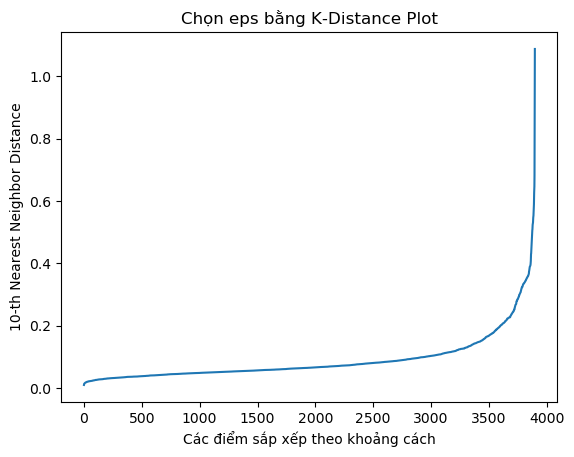

In [200]:
# Choose eps value
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(df_dbscan_scaled)
distances, _ = neigh.kneighbors(df_dbscan_scaled)

# Sắp xếp khoảng cách theo thứ tự tăng dần
sorted_distances = np.sort(distances[:, -1])

# Vẽ biểu đồ K-Distance Plot
plt.plot(sorted_distances)
plt.xlabel("Các điểm sắp xếp theo khoảng cách")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("Chọn eps bằng K-Distance Plot")
plt.show()

In [206]:
eps_values = np.arange(0.1, 0.4, 0.1)
min_samples = np.arange(4,7)

dbscan_params = list(product(eps_values, min_samples))

num_of_clusters = []
sil_score = []

for p in dbscan_params:
    dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit(df_dbscan_scaled)
    num_of_clusters.append(len(np.unique(dbscan.labels_)))
    sil_score.append(silhouette_score(df_dbscan_scaled, dbscan.labels_))

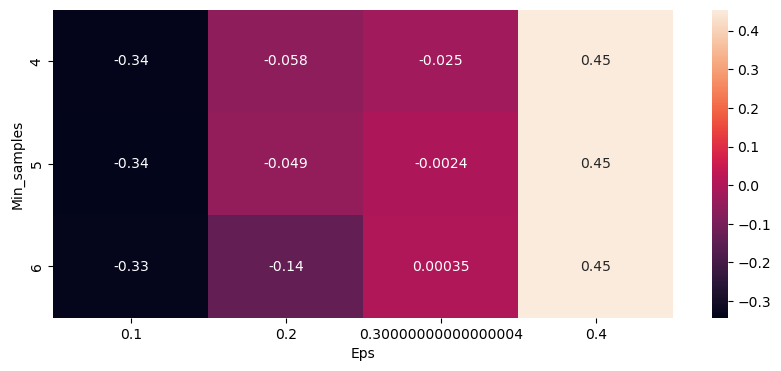

In [207]:
tmp = pd.DataFrame.from_records(dbscan_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, ax=ax)
plt.show()

- Chọn eps và min_samples tại đó giá trị Sihoutte lớn nhất => eps=15.5, min_samples = 4



In [208]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.4, min_samples=4)
labels = dbscan.fit_predict(df_dbscan_scaled)

# Count clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Estimated number of clusters: 1
Number of noise points: 25


In [209]:
from collections import Counter

cluster_counts = Counter(labels)
for cluster_id, count in sorted(cluster_counts.items()):
    if cluster_id == -1:
        print(f"Nhiễu (-1): {count} điểm")
    else:
        print(f"Cụm {cluster_id}: {count} điểm")

Nhiễu (-1): 25 điểm
Cụm 0: 3873 điểm


In [211]:
sil_dbscan=silhouette_score(df_dbscan_scaled[["Recency", "Monetary", "Frequency"]].values, labels, metric = 'euclidean')
print("Độ đo Silhoutte Score của DBSCAN:", sil_dbscan)

Độ đo Silhoutte Score của DBSCAN: 0.4524164821161596


#### Remove outliers data

In [190]:
df_dbscan_clean = df_RFM_clean[['Recency','Frequency','Monetary']]

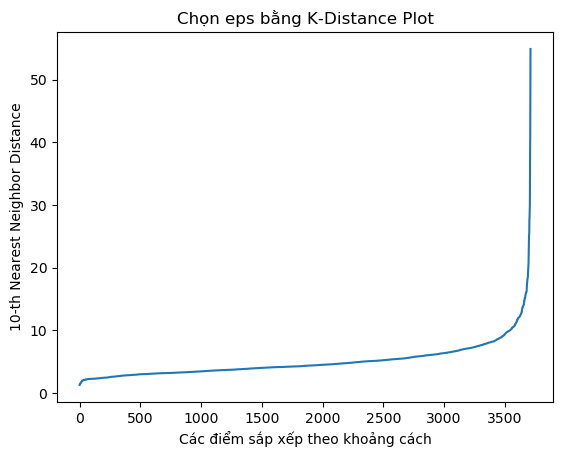

In [191]:
# Choose eps value
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(df_dbscan_clean)
distances, _ = neigh.kneighbors(df_dbscan_clean)

# Sắp xếp khoảng cách theo thứ tự tăng dần
sorted_distances = np.sort(distances[:, -1])

# Vẽ biểu đồ K-Distance Plot
plt.plot(sorted_distances)
plt.xlabel("Các điểm sắp xếp theo khoảng cách")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("Chọn eps bằng K-Distance Plot")
plt.show()

In [193]:
eps_values = np.arange(8,16, 0.5)
min_samples = np.arange(4,7)

dbscan_params = list(product(eps_values, min_samples))

num_of_clusters = []
sil_score = []

for p in dbscan_params:
    dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit(df_dbscan_clean)
    num_of_clusters.append(len(np.unique(dbscan.labels_)))
    sil_score.append(silhouette_score(df_dbscan_clean, dbscan.labels_))

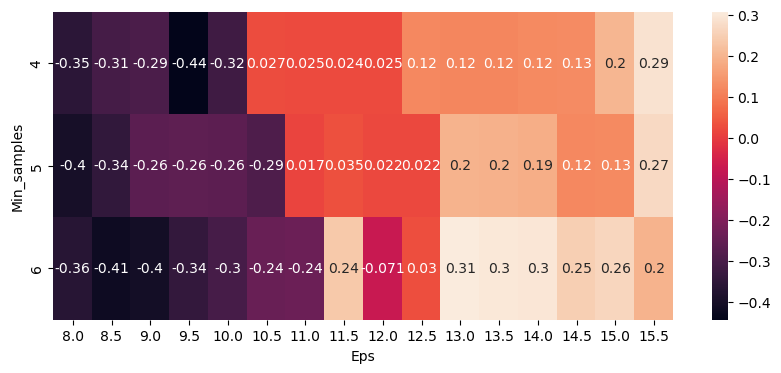

In [194]:
tmp = pd.DataFrame.from_records(dbscan_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, ax=ax)
plt.show()

- Chọn eps và min_samples tại đó giá trị Sihoutte lớn nhất => eps=13, min_samples = 6



In [195]:
# Apply DBSCAN
dbscan = DBSCAN(eps=13, min_samples=6)
labels = dbscan.fit_predict(df_dbscan_clean)

# Count clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Estimated number of clusters: 1
Number of noise points: 79


In [196]:
from collections import Counter

cluster_counts = Counter(labels)
for cluster_id, count in sorted(cluster_counts.items()):
    if cluster_id == -1:
        print(f"Nhiễu (-1): {count} điểm")
    else:
        print(f"Cụm {cluster_id}: {count} điểm")

Nhiễu (-1): 79 điểm
Cụm 0: 3634 điểm


In [197]:
for cluster_id in set(labels):
    if cluster_id == -1:
        continue
    cluster_points = df_dbscan_clean[labels == cluster_id]
    centroid = np.mean(cluster_points, axis=0)
    print(f"Tâm cụm {cluster_id}: {centroid}")

Tâm cụm 0: Recency      177.265272
Frequency      3.747936
Monetary      79.684015
dtype: float64


In [198]:
sil_dbscan=silhouette_score(df_dbscan_clean[["Recency", "Monetary", "Frequency"]].values, labels, metric = 'euclidean')
print("Độ đo Silhoutte Score của DBSCAN:", sil_dbscan)

Độ đo Silhoutte Score của DBSCAN: 0.30765270760459673


## RFM + Hierarchical Clustering



In [ ]:
df_hi = df_RFM[['Recency','Frequency','Monetary']]
df_hi.head()

Recency  Frequency  Monetary
Member_number                              
2193                91         11    361.45
1793                26         10    345.10
3289                 4         10    334.15
2433                 3          7    316.81
2743               142          7    312.46

### TH1: Scale dữ liệu

In [ ]:
from sklearn.preprocessing import StandardScaler

df_scaled = df_RFM[['Recency','Frequency','Monetary']]

# Instantiate
scaler = StandardScaler()

# fit_transform
df_hi_scaled = scaler.fit_transform(df_scaled)
df_hi_scaled.shape

(3898, 3)

In [ ]:
df_hi_scaled = pd.DataFrame(df_hi_scaled, columns=df_scaled.columns)
df_hi_scaled.head()

Recency  Frequency  Monetary
0 -0.604791   3.802287  4.997257
1 -1.011315   3.271342  4.701815
2 -1.148908   3.271342  4.503951
3 -1.155162   1.678509  4.190620
4 -0.285826   1.678509  4.112016

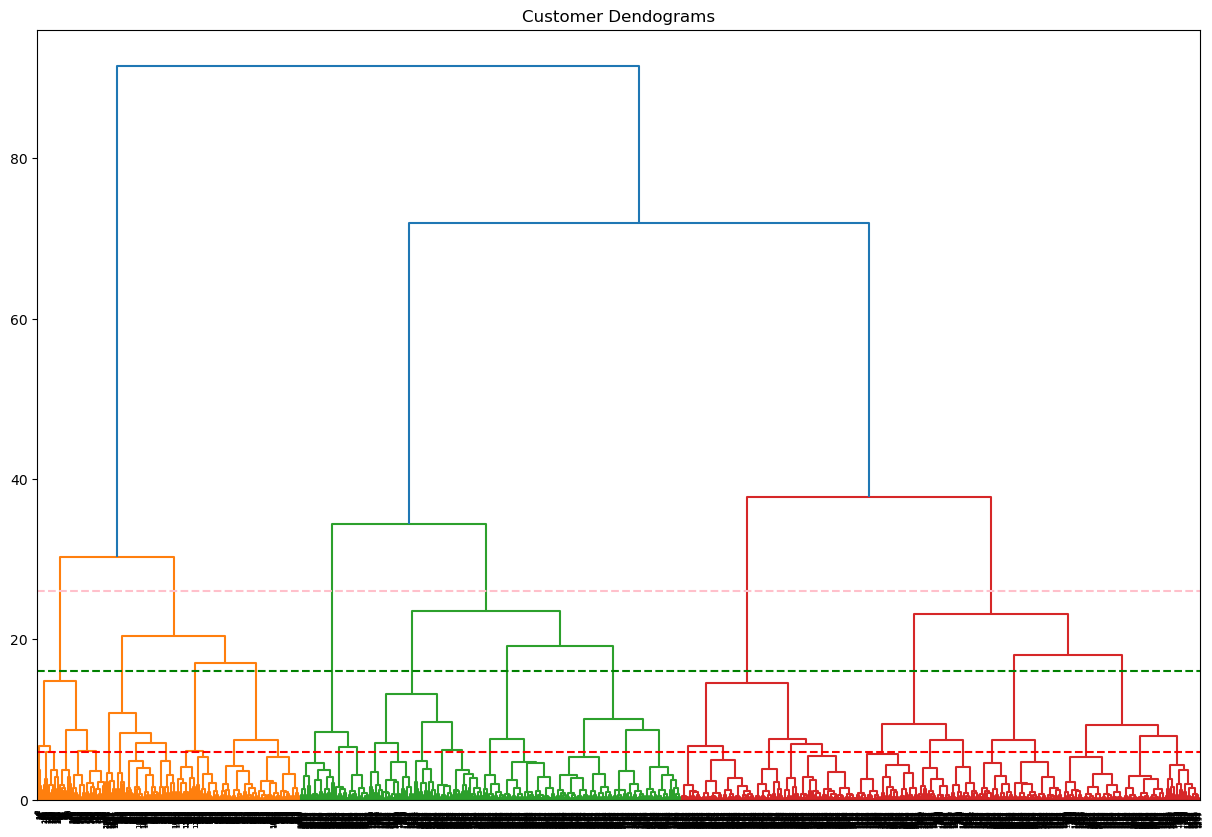

In [ ]:
from scipy.cluster import hierarchy
plt.figure(figsize=(15, 10))
plt.title('Customer Dendograms')
dend = hierarchy.dendrogram(hierarchy.linkage(df_hi_scaled[['Recency', 'Frequency', 'Monetary']], method='ward'))
plt.axhline(y=6, color='r', linestyle='--')
plt.axhline(y=16, color='green', linestyle='--')
plt.axhline(y=26, color='pink', linestyle='--')
plt.show()

- Biểu đồ trên chính là khoảng cách cụm được tính theo phương pháp Ward linkage. Nhìn vào đồ thị dendrogram ta có thể dễ dàng xác định được rằng với cùng một giá trị mức độ khác biệt là 26 thì chúng ta có thể tạo thành 6 cụm phân biệt

In [ ]:
# Initiating the Agglomerative Clustering model with K=6
from sklearn.cluster import AgglomerativeClustering
AC_1 = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')

# Fit model and predict clusters
y_1 = AC_1.fit_predict(df_hi_scaled)
df_hi_scaled['Clusters'] = y_1

In [ ]:
df_hi_scaled

Recency  Frequency  Monetary  Clusters
0    -0.604791   3.802287  4.997257         5
1    -1.011315   3.271342  4.701815         5
2    -1.148908   3.271342  4.503951         5
3    -1.155162   1.678509  4.190620         5
4    -0.285826   1.678509  4.112016         5
...        ...        ...       ...       ...
3893  2.534825  -1.507158 -1.499747         4
3894  1.390303  -1.507158 -1.503361         0
3895  1.509133  -1.507158 -1.505168         0
3896  1.627963  -1.507158 -1.510589         0
3897 -1.173925  -1.507158 -1.514203         3

[3898 rows x 4 columns]

In [ ]:
AC_1.labels_

array([5, 5, 5, ..., 0, 0, 3])

In [ ]:
from collections import Counter
c_1 = Counter(AC_1.labels_)
c_1

Counter({np.int64(5): 229,
         np.int64(1): 654,
         np.int64(2): 1154,
         np.int64(0): 1048,
         np.int64(4): 228,
         np.int64(3): 585})

In [ ]:
df_hi_scaled.groupby('Clusters').agg({'Recency':'mean',
                                      'Frequency':'mean',
                                      'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
            mean      mean     mean count
Clusters                                 
0           0.84     -0.61    -0.53  1048
1          -0.37      0.98     1.07   654
2          -0.60      0.27     0.01  1154
3          -0.60     -0.78    -0.83   585
4           2.46     -1.17    -1.01   228
5          -0.65      1.78     2.47   229

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_hi = df_hi_scaled.groupby('Clusters').agg({'Recency': 'mean',
                                               'Frequency': 'mean',
                                               'Monetary': ['mean', 'count']}).round(0)

rfm_hi.columns = rfm_hi.columns.droplevel()
rfm_hi.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_hi['Percent'] = round((rfm_hi['Count']/rfm_hi.Count.sum())*100, 2)

# Reset the index
rfm_hi = rfm_hi.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_hi['Clusters'] = 'Cluster '+ rfm_hi['Clusters'].astype('str')

# Print the aggregated dataset
rfm_hi

Clusters  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0          1.0           -1.0          -1.0   1048    26.89
1  Cluster 1         -0.0            1.0           1.0    654    16.78
2  Cluster 2         -1.0            0.0           0.0   1154    29.60
3  Cluster 3         -1.0           -1.0          -1.0    585    15.01
4  Cluster 4          2.0           -1.0          -1.0    228     5.85
5  Cluster 5         -1.0            2.0           2.0    229     5.87

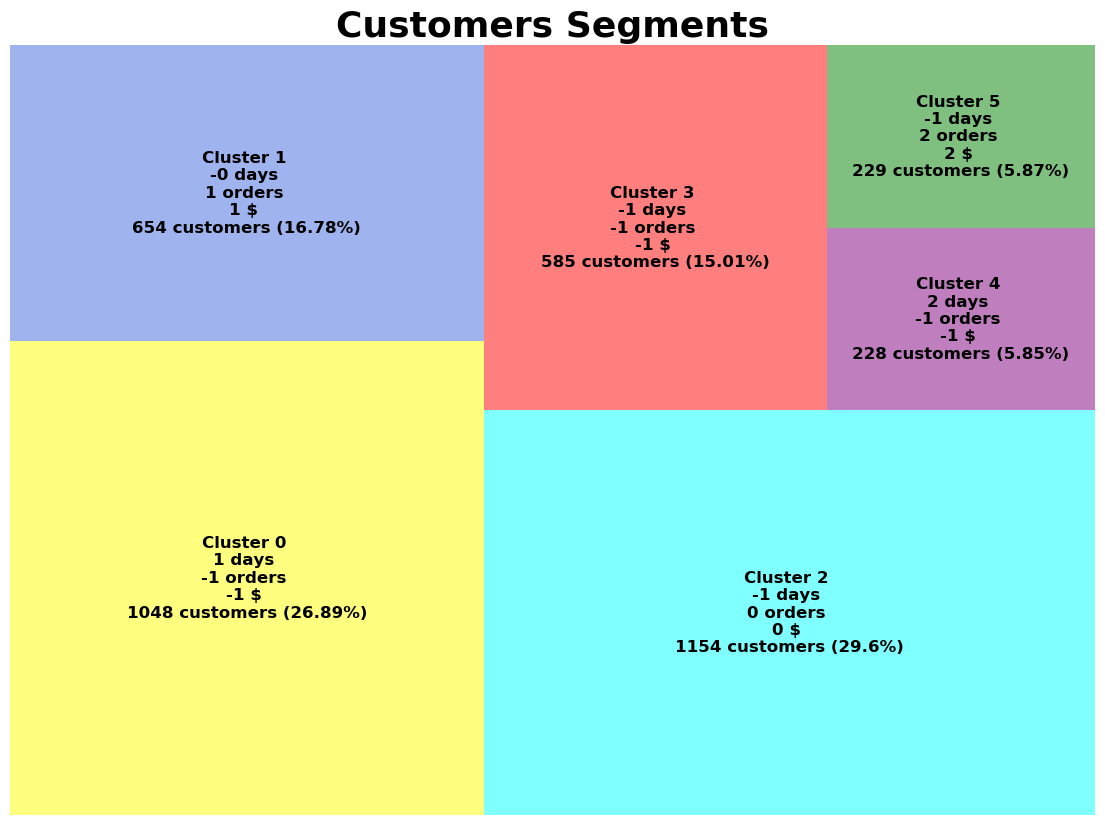

In [ ]:
# Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow', 'Cluster1':'royalblue', 'Cluster2':'cyan', 'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green'}

squarify.plot(sizes=rfm_hi['Count'],
              text_kwargs={'fontsize':12, 'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_hi.iloc[i])
                      for i in range(0, len(rfm_hi))], alpha=0.5 )


plt.title("Customers Segments", fontsize=26, fontweight="bold")
plt.axis('off')
plt.show()

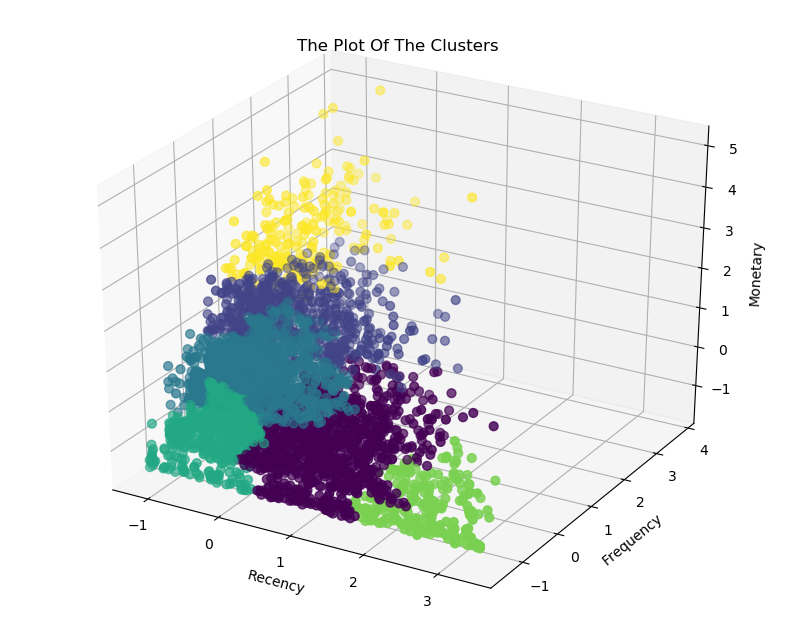

In [ ]:
# Plotting the clusters
x = df_hi_scaled['Recency']
y = df_hi_scaled['Frequency']
z = df_hi_scaled['Monetary']
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=df_hi_scaled['Clusters'], marker='o')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('The Plot Of The Clusters')
plt.show()

<ipython-input-112-64c3303249ba>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-112-64c3303249ba>:3: UserWarning:


The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.



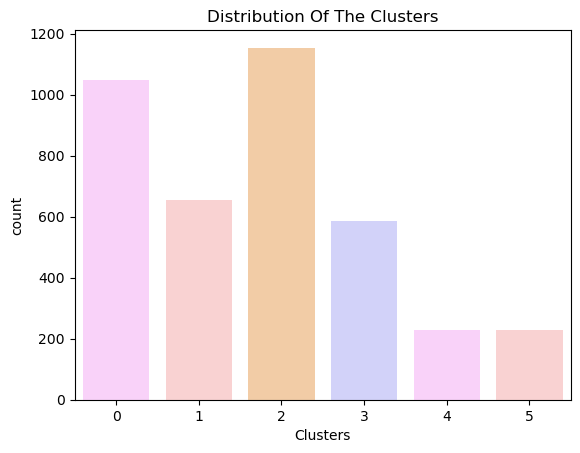

In [ ]:
# Plotting countplot of clusters
pal = ["#FFCCFF","#FFCCCC", "#FFCC99","#CCCCFF"]
pl = sns.countplot(x=df_hi_scaled['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

### TH2: Không scale dữ liệu

#### K=6

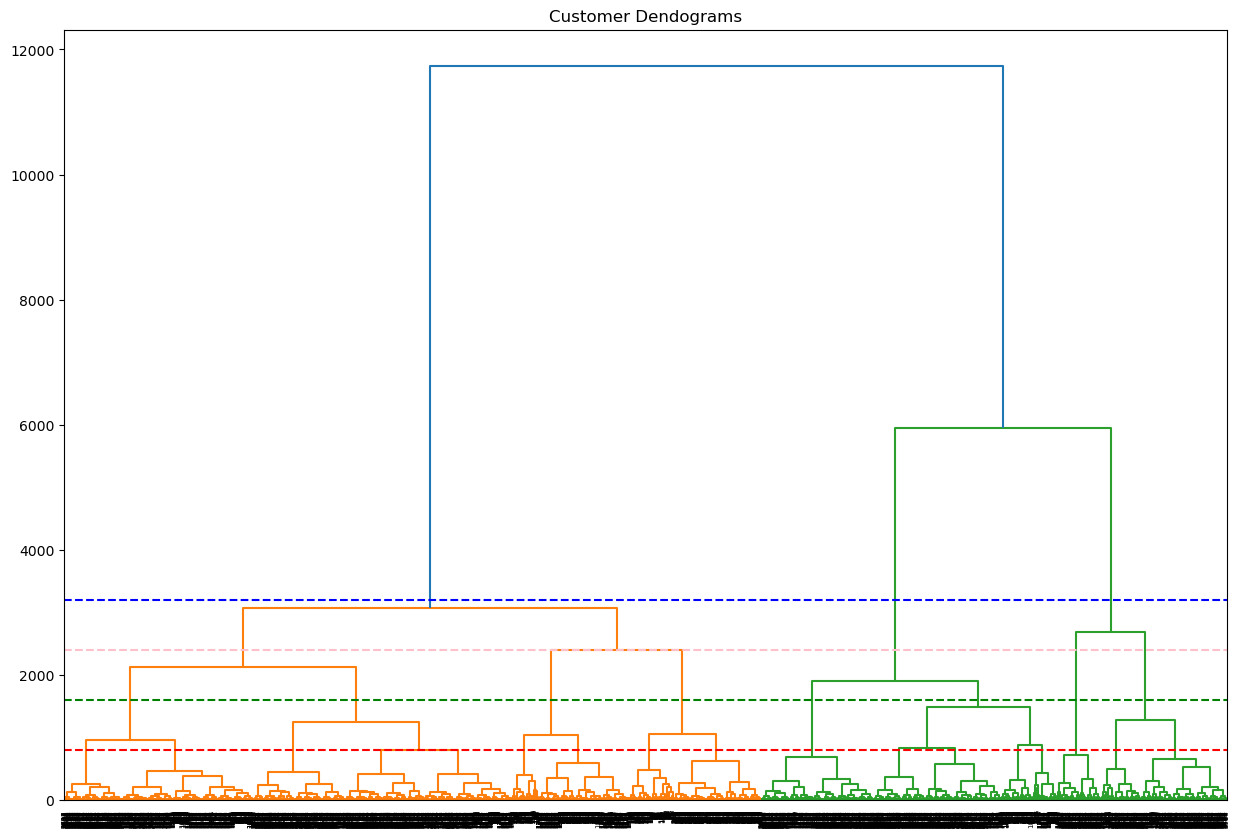

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Customer Dendograms')
dend_hi = hierarchy.dendrogram(hierarchy.linkage(df_hi[['Recency', 'Frequency', 'Monetary']], method='ward'))
plt.axhline(y=800, color='r', linestyle='--')
plt.axhline(y=1600, color='green', linestyle='--')
plt.axhline(y=2400, color='pink', linestyle='--')
plt.axhline(y=3200, color='blue', linestyle='--')
plt.show()

- Biểu đồ trên chính là khoảng cách cụm được tính theo phương pháp Ward linkage. Nhìn vào đồ thị dendrogram, với tập dữ liệu không scale, có thể xác định được rằng với cùng một giá trị mức độ khác biệt là 1600 thì chúng ta có thể tạo thành 8 cụm phân biệt. Hoặc ta có thể chia thành 4 nhóm với cùng một giá trị mức độ khác biệt là 2400

In [ ]:
# Initiating the Agglomerative Clustering model with K=6
from sklearn.cluster import AgglomerativeClustering
AC_2 = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')

# Fit model and predict clusters
y_2 = AC_2.fit_predict(df_hi)
df_hi['Clusters'] = y_2

<ipython-input-114-cc7c48dc99d3>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_hi

Recency  Frequency  Monetary  Clusters
Member_number                                        
2193                91         11    361.45         3
1793                26         10    345.10         3
3289                 4         10    334.15         3
2433                 3          7    316.81         3
2743               142          7    312.46         5
...                ...        ...       ...       ...
1560               593          1      1.90         4
1221               410          1      1.70         1
4029               429          1      1.60         1
1250               448          1      1.30         1
4565                 0          1      1.10         0

[3898 rows x 4 columns]

In [ ]:
AC_2.labels_

array([3, 3, 3, ..., 1, 1, 0])

In [ ]:
c_2 = Counter(AC_2.labels_)
c_2

Counter({np.int64(3): 442,
         np.int64(5): 394,
         np.int64(2): 994,
         np.int64(1): 420,
         np.int64(0): 1502,
         np.int64(4): 146})

In [ ]:
df_hi.groupby('Clusters').agg({'Recency':'mean',
                               'Frequency':'mean',
                               'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
            mean      mean     mean count
Clusters                                 
0          69.82      3.73    69.92  1502
1         441.87      2.53    48.00   420
2         268.53      3.29    69.05   994
3          48.41      6.25   179.57   442
4         623.15      1.70    31.87   146
5         157.13      5.14   134.74   394

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_hi_2 = df_hi.groupby('Clusters').agg({'Recency': 'mean',
                                          'Frequency': 'mean',
                                          'Monetary': ['mean', 'count']}).round(0)

rfm_hi_2.columns = rfm_hi_2.columns.droplevel()
rfm_hi_2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_hi_2['Percent'] = round((rfm_hi_2['Count']/rfm_hi_2.Count.sum())*100, 2)

# Reset the index
rfm_hi_2 = rfm_hi_2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_hi_2['Clusters'] = 'Cluster '+ rfm_hi_2['Clusters'].astype('str')

# Print the aggregated dataset
rfm_hi_2

Clusters  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0         70.0            4.0          70.0   1502    38.53
1  Cluster 1        442.0            3.0          48.0    420    10.77
2  Cluster 2        269.0            3.0          69.0    994    25.50
3  Cluster 3         48.0            6.0         180.0    442    11.34
4  Cluster 4        623.0            2.0          32.0    146     3.75
5  Cluster 5        157.0            5.0         135.0    394    10.11

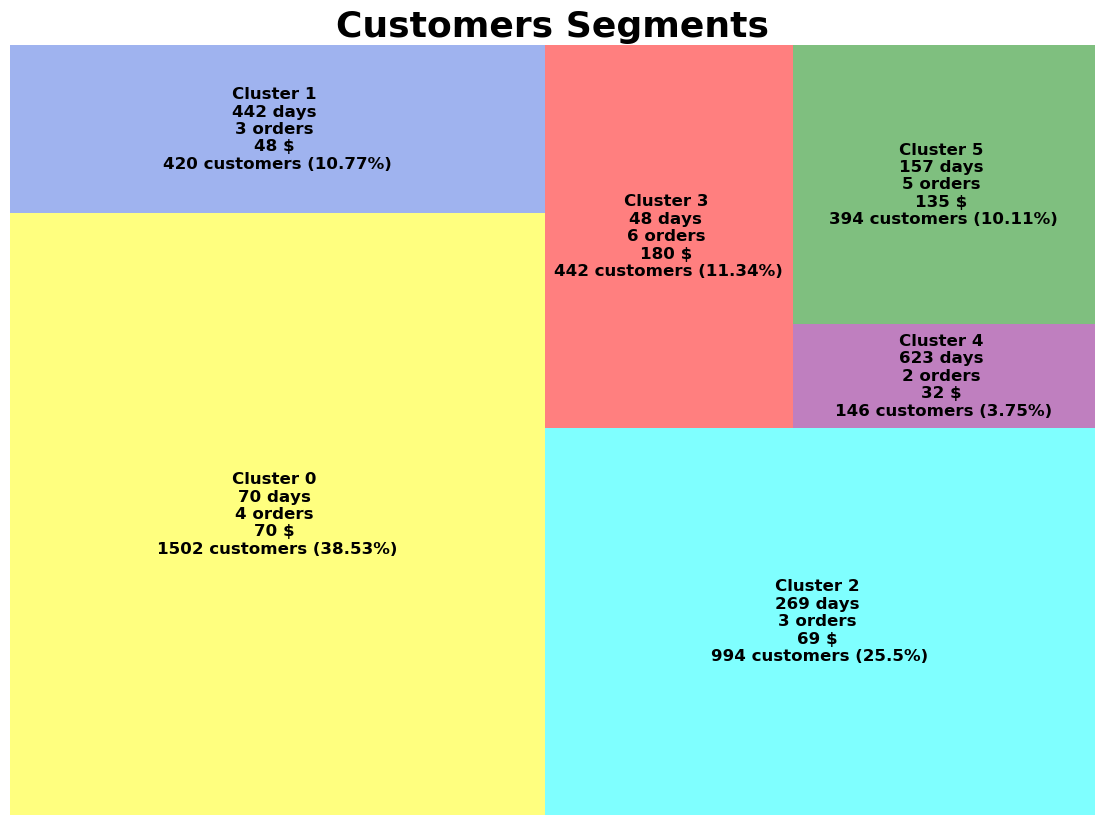

In [ ]:
# Treemap
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow', 'Cluster1':'royalblue', 'Cluster2':'cyan', 'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green'}

squarify.plot(sizes=rfm_hi_2['Count'],
              text_kwargs={'fontsize':12, 'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_hi_2.iloc[i])
                      for i in range(0, len(rfm_hi_2))], alpha=0.5 )


plt.title("Customers Segments", fontsize=26, fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
# Scatter plot
fig = px.scatter(rfm_hi_2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Clusters", hover_name="Clusters", size_max=100)
fig.show()

- Cluster 3 (chiếm 11%) : với tần suất mua sắm trung bình 6 lần, chi tiêu lớn nhất (180) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 1 tháng => Là nhóm khách hàng mang lại doanh thu lớn nhất cho cửa hàng khi mua hàng thường xuyên và chi tiêu rất nhiều (HARDCORE)
- Cluster 0 (chiếm 39%) : với tần suất mua sắm trung bình 4 lần, chi tiêu trung bình (70) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 2 tháng => Là nhóm khách hàng mua hàng thường xuyên (LOYAL)
- Cluster 5 (chiếm 10%) : với tần suất mua sắm trung bình 5 lần, chi tiêu cao (135) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 5 tháng
- Cluster 2 (chiếm 26%) : với tần suất mua sắm trung bình 3 lần, chi tiêu trung bình (69) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 15 tháng
- Cluster 1 (chiếm 11%) : với tần suất mua sắm trung bình 3 lần, chi tiêu thấp (48) và lần mua gần nhất cách thời gian ghi nhận dữ liệu 11 tháng => Là nhóm khách hàng có nguy cơ rời bỏ cửa hàng khi đã lâu không mua hàng và giá trị mua hàng cũng không cao (AT RISK)
- Cluster 4 (chiếm 12%) : với tần suất mua sắm trung bình 2 lần, chi tiêu rất thấp (32) và lần mua gần nhất cách thời gian ghi nhận dữ liệu hơn gần 2 năm => Là nhóm khách hàng không còn tương tác với cửa hàng và giá trị mua hàng rất thấp (LOST)

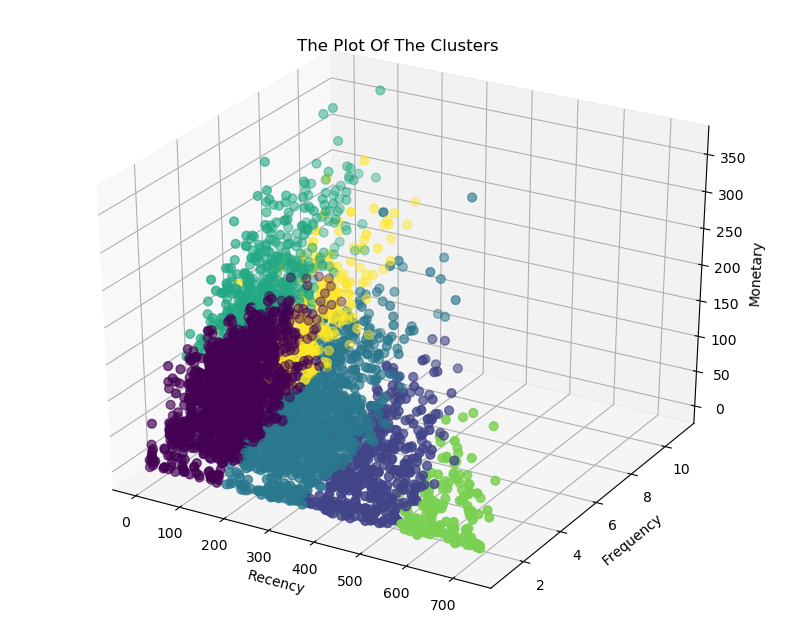

In [ ]:
# Plotting the clusters
x = df_hi['Recency']
y = df_hi['Frequency']
z = df_hi['Monetary']
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=df_hi['Clusters'], marker='o')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('The Plot Of The Clusters')
plt.show()

<ipython-input-123-17d6e760c77f>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-123-17d6e760c77f>:3: UserWarning:


The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.



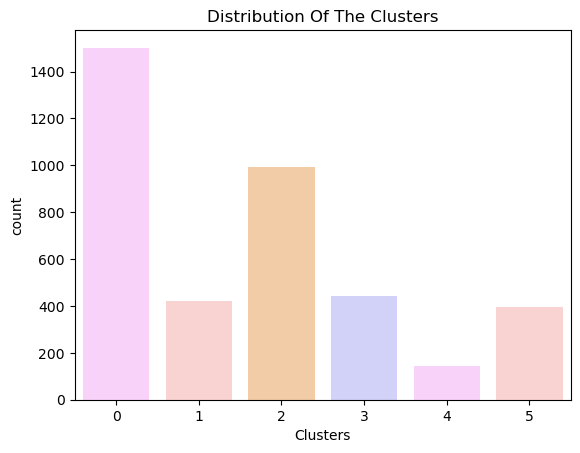

In [ ]:
# Plotting countplot of clusters
pal = ["#FFCCFF","#FFCCCC", "#FFCC99","#CCCCFF"]
pl = sns.countplot(x=df_hi['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

In [ ]:
sil_hi=silhouette_score(df_hi[["Recency", "Monetary", "Frequency"]].values, df_hi['Clusters'], metric = 'euclidean')
print("Độ đo Silhoutte Score của Hierarchical Clustering:", sil_hi)

Độ đo Silhoutte Score của Hierarchical Clustering: 0.32527610794110656


#### K=4

In [ ]:
# Initiating the Agglomerative Clustering model with K=4
df_hi_3 = df_RFM[['Recency','Frequency','Monetary']]

AC_3 = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')

# Fit model and predict clusters
y_3 = AC_3.fit_predict(df_hi_3)
df_hi_3['Clusters'] = y_3

<ipython-input-126-ca1c7a8f4544>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_hi_3

Recency  Frequency  Monetary  Clusters
Member_number                                        
2193                91         11    361.45         1
1793                26         10    345.10         1
3289                 4         10    334.15         1
2433                 3          7    316.81         1
2743               142          7    312.46         1
...                ...        ...       ...       ...
1560               593          1      1.90         0
1221               410          1      1.70         0
4029               429          1      1.60         0
1250               448          1      1.30         0
4565                 0          1      1.10         3

[3898 rows x 4 columns]

In [ ]:
AC_3.labels_

array([1, 1, 1, ..., 0, 0, 3])

In [ ]:
c_3 = Counter(AC_3.labels_)
c_3

Counter({np.int64(1): 836,
         np.int64(2): 994,
         np.int64(0): 566,
         np.int64(3): 1502})

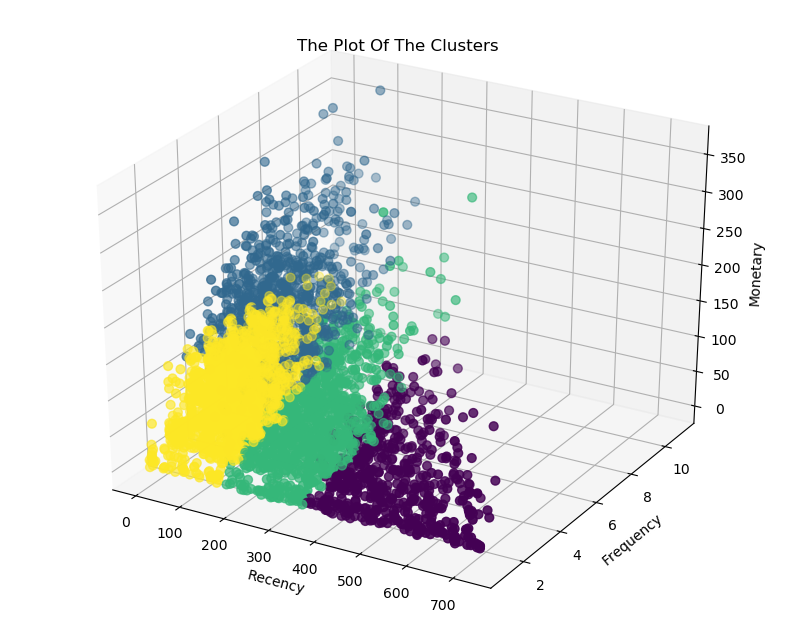

In [ ]:
# Plotting the clusters
x = df_hi_3['Recency']
y = df_hi_3['Frequency']
z = df_hi_3['Monetary']
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=df_hi_3['Clusters'], marker='o')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('The Plot Of The Clusters')
plt.show()

<ipython-input-131-331736497ab7>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




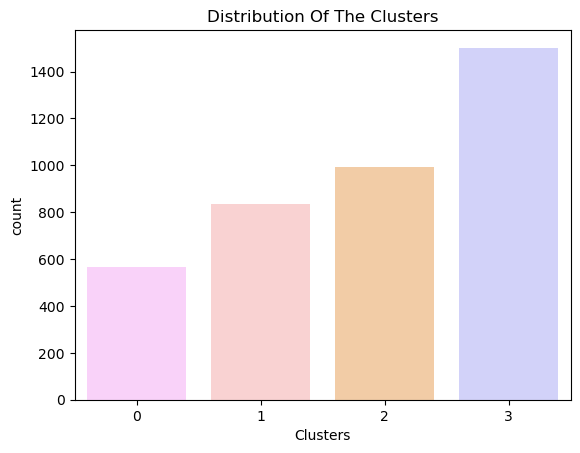

In [ ]:
# Plotting countplot of clusters
pal = ["#FFCCFF","#FFCCCC", "#FFCC99","#CCCCFF"]
pl = sns.countplot(x=df_hi_3['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

- Nhận xét: Với K=4, mặc dù các cụm tách biệt khá rõ ràng, tuy nhiên do độ rộng của bộ dữ liệu nên việc phân chia KH thành 4 nhóm không thể hiện được hết ý nghĩa của từng nhóm KH -> loại bỏ trường hợ K=4

#### K=8

In [ ]:
# Initiating the Agglomerative Clustering model with K=8
df_hi_4 = df_RFM[['Recency','Frequency','Monetary']]

AC_4 = AgglomerativeClustering(n_clusters=8, metric='euclidean', linkage='ward')

# Fit model and predict clusters
y_4 = AC_4.fit_predict(df_hi_4)
df_hi_4['Clusters'] = y_4

<ipython-input-132-286516f3611d>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_hi_4

Recency  Frequency  Monetary  Clusters
Member_number                                        
2193                91         11    361.45         3
1793                26         10    345.10         3
3289                 4         10    334.15         3
2433                 3          7    316.81         3
2743               142          7    312.46         5
...                ...        ...       ...       ...
1560               593          1      1.90         4
1221               410          1      1.70         1
4029               429          1      1.60         1
1250               448          1      1.30         1
4565                 0          1      1.10         6

[3898 rows x 4 columns]

In [ ]:
AC_4.labels_

array([3, 3, 3, ..., 1, 1, 6])

In [ ]:
c_4 = Counter(AC_4.labels_)
c_4

Counter({np.int64(3): 442,
         np.int64(5): 394,
         np.int64(0): 615,
         np.int64(1): 420,
         np.int64(6): 637,
         np.int64(2): 865,
         np.int64(7): 379,
         np.int64(4): 146})

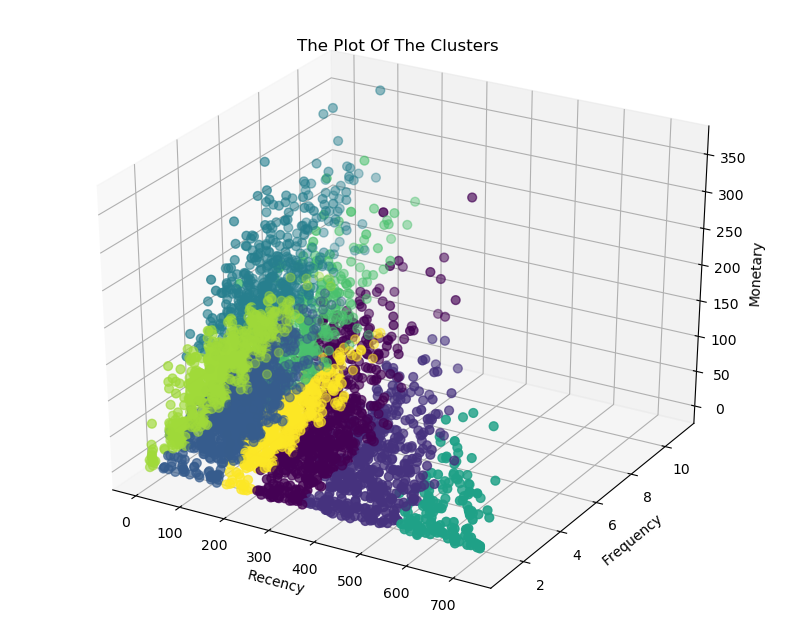

In [ ]:
# Plotting the clusters
x = df_hi_4['Recency']
y = df_hi_4['Frequency']
z = df_hi_4['Monetary']
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=df_hi_4['Clusters'], marker='o')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('The Plot Of The Clusters')
plt.show()

<ipython-input-137-a4b43fe32531>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-137-a4b43fe32531>:3: UserWarning:


The palette list has fewer values (4) than needed (8) and will cycle, which may produce an uninterpretable plot.



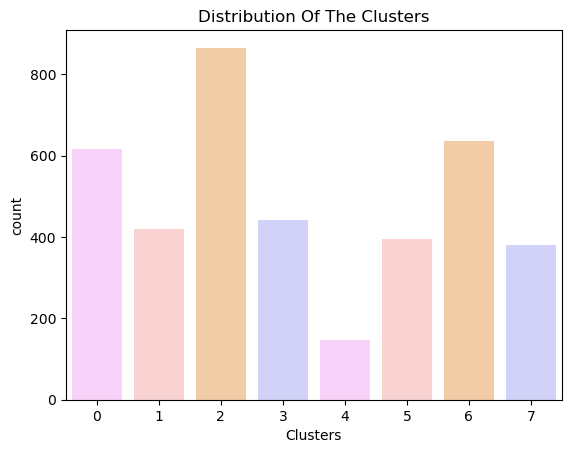

In [ ]:
# Plotting countplot of clusters
pal = ["#FFCCFF","#FFCCCC", "#FFCC99","#CCCCFF"]
pl = sns.countplot(x=df_hi_4['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

- Nhận xét: Nhận xét: Với K=8, các cụm trộn lẫn vào nhau, không phân thành từng cụm riêng biệt nên ta loại bỏ trường hợp này

- Nhận xét: Theo em tìm hiểu, Hierarchical dù là thuật toán khá hiệu quả nhưng phân cụm phân cấp lại có chi phí tính toán khá lớn, lên tới O(N^3). Do đó chỉ nên áp dụng phương pháp này đối với những bộ dữ liệu có kích thước vừa phải